## Appendix/Code: Titanic
 - Data related to the sinking of the Titanic was utilized to evaluate two classifier models using three methods (Logistic Regression, Gaussian Naive Bayes, and Bernoulli Bayes) within a 10-fold cross validation design. Data was tested using the ROC curve, ROC AUC, F1 score, Precision and Recall scores, and Accuracy score and evaluation metrics. 

### Import Libraries for Analysis:

In [242]:
#For data
import pandas as pd

#For math
import numpy as np

#For data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from PIL import Image
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

#For statistics
from scipy import stats
from scipy.stats import kurtosis, skew, norm
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import researchpy as rp

#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))


#Ignore warning from sklearn and seaborn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

#For regex and random
import re
import random
from numpy.random import seed

In [243]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Examing Dataset and Initial Prepreparation for Examining Training Set:

In [244]:
#Display the first five rows of the train dataset.
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [245]:
#Display the first five rows of the test dataset.
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.500,0,0,330911,7.829,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000,1,0,363272,7.000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.000,0,0,240276,9.688,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.000,0,0,315154,8.662,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000,1,1,3101298,12.287,NaN,S


In [246]:
#Dropping the ID
#Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['PassengerId']
test_ID = test['PassengerId']

#Drop 'Id' column since it's unnecessary for the prediction process.
train.drop("PassengerId", axis = 1, inplace = True)
test.drop("PassengerId", axis = 1, inplace = True)

#Check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (891, 12) 
The test data size before dropping Id feature is : (418, 11) 

The train data size after dropping Id feature is : (891, 11) 
The test data size after dropping Id feature is : (418, 10) 


### Missing Data From Training Set:

In [247]:
total = train.isnull().sum().sort_values(ascending=False)
percent_1 = train.isnull().sum()/train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.100
Age,177,19.900
Embarked,2,0.200
Fare,0,0.000
Ticket,0,0.000


In [248]:
#Copy training set for analysis
by_title = train.copy()

### Imputing Missing Age with Mean Age by Title and Adding Title to Dataframe:

In [249]:
#Getting mean age by title and adding title to dataframe
title = by_title['Name'].str.extract(r'\b(\w+)\.') #getting ranks using regex
by_title['Title'] = title
title_mean = dict(round(by_title['Age'].groupby(by_title['Title']).mean()))
title_mean

{'Capt': 70.0,
 'Col': 58.0,
 'Countess': 33.0,
 'Don': 40.0,
 'Dr': 42.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.0,
 'Master': 5.0,
 'Miss': 22.0,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 32.0,
 'Mrs': 36.0,
 'Ms': 28.0,
 'Rev': 43.0,
 'Sir': 49.0}

In [250]:
#Impute mean values with fill function by title
fill_func = lambda g: g.fillna(title_mean[g.name])
mean_missing_age_by_title = by_title['Age'].groupby(by_title['Title']).apply(fill_func)
by_title['Age'] = mean_missing_age_by_title
check = by_title['Age']==train['Age']
check.value_counts()

True     714
False    177
Name: Age, dtype: int64

### Create Decks by Cabin Letter and Imputing Missing Values By Class Using Random Choice Generator:
 - With the 687 missing cabin values, decks were created by cabin letter, with 1 being the highest deck, and 7 being the lowest deck. Missing values of deck numbers were imputed with a random choice generator by class with a seed of 500.  
 - Though not recommended the random choice generator used to impute missing values showed a close percentage distribution to the data that was available.
 - Validation tests showed that it was reasonable to include the imputed values.

In [251]:
def fill_with_random(df2, column):
    '''Fill `df2`'s column with name `column` with random data based on non-NaN data from `column`'''
    df = df2.copy()
    seed(500)
    df[column] = df[column].apply(lambda x: np.random.choice(df[column].dropna().values) if np.isnan(x) else x)
    return df

In [252]:
deck = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 1}
for i in by_title:
    by_title['Cabin'] = by_title['Cabin'].fillna('U0')
    by_title['Deck'] = by_title['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    by_title['Deck'] = by_title['Deck'].map(deck)

### Evaluation Decks by Percentage with Data that is Available:
 - These were be compared to imputation of missing values with a random choice method to see if the distributions are similar.
 - Since they were similar, the study advanced using the imputed values.
 - However, this is not recommended, as there were 687 missing values out of 891 in the training set, unless there is a significant influence on scoring. In this study imputation seemed to have a positive influence on validation scores (not shown in this index) as they scored better than imputing the values as 0.
 - Titanic deck plans also showed that most 3rd class passengers were situated in the lower decks (5, 6, 7), and other class passengers were in the higher decks. Since there was a higher rate of 3rd class passengers that perished, it is reasonable assumption to distribute missing values of cabin decks by class. Other methods of imputation are recommended however. 

In [253]:
deck_test = by_title.copy()
deck_test = pd.DataFrame(deck_test.groupby(['Pclass', 'Deck'])['Deck'].count())
deck_test = deck_test.rename(columns={'Deck':'Count'})
deck_test = deck_test.reset_index()
print('Deck Distribution, Decks 1 to 5, By Percentage in Ascending Order By Deck Passenger Class 1:')
print(deck_test.loc[deck_test['Pclass']==1].Count/deck_test.loc[deck_test['Pclass']==1].Count.sum(), '\n')
print('Deck Distribution, Decks 4 to 6, By Percentage in Ascending Order By Deck Passenger Class 2:')
print(deck_test.loc[deck_test['Pclass']==2].Count/deck_test.loc[deck_test['Pclass']==2].Count.sum(), '\n')
print('Deck Distribution, Decks 5 to 7, By Percentage in Ascending Order By Deck Passenger Class 3:')
print(deck_test.loc[deck_test['Pclass']==3].Count/deck_test.loc[deck_test['Pclass']==3].Count.sum())

Deck Distribution, Decks 1 to 5, By Percentage in Ascending Order By Deck Passenger Class 1:
0   0.091
1   0.267
2   0.335
3   0.165
4   0.142
Name: Count, dtype: float64 

Deck Distribution, Decks 4 to 6, By Percentage in Ascending Order By Deck Passenger Class 2:
5   0.250
6   0.250
7   0.500
Name: Count, dtype: float64 

Deck Distribution, Decks 5 to 7, By Percentage in Ascending Order By Deck Passenger Class 3:
8    0.250
9    0.417
10   0.333
Name: Count, dtype: float64


### Imputing Missing Values of Deck by Passenger Class Using Random Choice Method:
 - Percentage distribution by deck shows that they are somewhat close to the figures computed above

In [254]:
# Impute deck number by passenger class 1
class_1 = by_title.loc[by_title['Pclass']==1]
class_1 = fill_with_random(class_1, 'Deck')
pd.DataFrame(class_1['Deck'].value_counts()/class_1['Deck'].count().sum()).sort_index()

,Deck
1.000,0.093
2.000,0.273
3.000,0.343
4.000,0.157
5.000,0.134


In [255]:
# Impute deck number by passenger class 2
class_2 = by_title.loc[by_title['Pclass']==2]
class_2 = fill_with_random(class_2, 'Deck')
pd.DataFrame(class_2['Deck'].value_counts()/class_1['Deck'].count().sum()).sort_index()

,Deck
4.000,0.213
5.000,0.218
6.000,0.421


In [256]:
# Impute deck number by passenger class 3
class_3 = by_title.loc[by_title['Pclass']==3]
class_3 = fill_with_random(class_3, 'Deck')
pd.DataFrame(class_3['Deck'].value_counts()/class_3['Deck'].count().sum()).sort_index()

,Deck
5.000,0.232
6.000,0.432
7.000,0.336


In [257]:
#Merge imputed decks by class back to data frame
by_title = pd.concat([class_1, class_2, class_3])
by_title['Deck'] = by_title['Deck'].astype(int)
by_title.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,Mrs,3
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,Mrs,3
6,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S,Mr,5
11,1,1,"Bonnell, Miss. Elizabeth",female,58.000,0,0,113783,26.550,C103,S,Miss,3
23,1,1,"Sloper, Mr. William Thompson",male,28.000,0,0,113788,35.500,A6,S,Mr,1


### Imputing Embarked With Most Common:
 - As there were only two missing values, it was reasonable to use the most common occuring.

In [258]:
by_title['Embarked'] = by_title['Embarked'].fillna(by_title['Embarked'].mode()[0])

### Check for Additional Missing Values:

In [259]:
by_title.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
Title       0
Deck        0
dtype: int64

## Data Exploration and Visualization:

### Initial Descriptive Statistics:
 - It is interesting to see that median age was 30 years old, fare was $14.54 dollars (a lot for that time), passenger class was 3, and median deck was 6 (which can be disputed because of missing values). 

In [260]:
by_title.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare,Deck
count,891.000,891.000,891.000,891.000,891.000,891.000,891.000
mean,0.384,2.309,29.718,0.523,0.382,32.204,5.166
std,0.487,0.836,13.260,1.103,0.806,49.693,1.560
min,0.000,1.000,0.420,0.000,0.000,0.000,1.000
25%,0.000,2.000,22.000,0.000,0.000,7.910,4.000
50%,0.000,3.000,30.000,0.000,0.000,14.454,6.000
75%,1.000,3.000,36.000,1.000,0.000,31.000,6.000
max,1.000,3.000,80.000,8.000,6.000,512.329,7.000


### Median Statistics by Name Title:
 - Looking at characteristics by title shows some interesting facts such as most passenger classes with passengers with titles of respect were in first class, and they were traveling alone. The median fare for name titles with Mrs. were also fairly high in comparison to those with the name titles with Mr.

In [261]:
#Median statistics by title
count = by_title.groupby('Title')['Survived'].count()
count = count.rename(columns={'Survived':'Count'})
by_title_stats = by_title.groupby('Title').median().drop(columns='Survived')
by_title_stats['Count'] = count
by_title_stats.transpose()

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Pclass,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,3.000,3.000,1.000,1.000,3.000,2.000,2.000,2.000,1.000
Age,70.000,58.000,33.000,40.000,44.000,38.000,48.000,48.500,4.000,22.000,24.000,24.000,32.000,36.000,28.000,46.500,49.000
SibSp,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000
Parch,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Fare,71.000,31.025,86.500,27.721,30.500,0.000,39.600,28.525,29.062,15.621,59.402,69.300,9.350,26.000,13.000,13.000,56.929
Deck,2.000,1.500,2.000,2.000,4.000,4.000,1.000,2.500,6.000,6.000,2.500,2.000,6.000,5.000,4.000,5.000,1.000
Count,1.000,2.000,1.000,1.000,7.000,1.000,1.000,2.000,40.000,182.000,2.000,1.000,517.000,125.000,1.000,6.000,1.000


### Plot of Number of Passengers by Name Title:
 - Log 10 scaling was used in plotting as there were significant difference in counts.

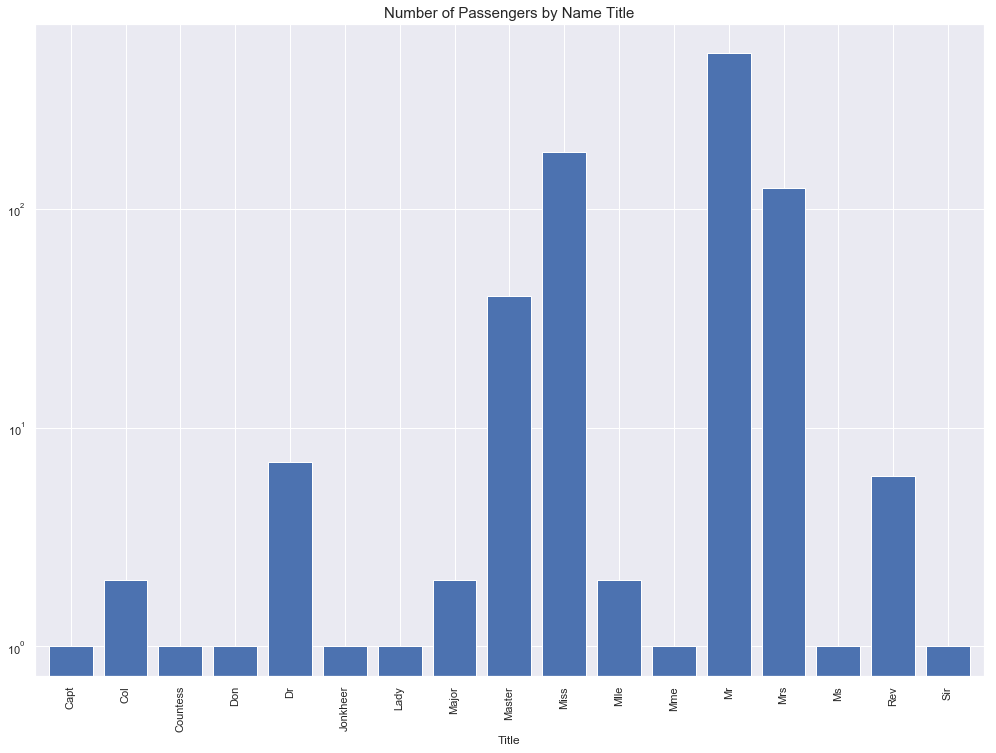

In [262]:
# Count of Passengers by Title plot:
by_title_stats['Count'].plot(kind='bar', width=0.8, figsize=(17, 12));
plt.yscale('log')
plt.title('Number of Passengers by Name Title', fontsize='15')
plt.savefig('Number of Passengers by Title')
plt.show();

### Median Statistics of Those That Survived by Name Title:
 - Counts show a significant difference in the amount of name titles with Mr. survived compared to how many were on board. There were 512 passengers with that name title and only 81 survived (also 2nd class). Also, an interesting fact males with name titles of nobility or respect mostly perished, while females of the same class survived. Median fares of those survived were fairly quite high as well.   

In [263]:
#Median statistics of survived by name title
by_title_surv = by_title.loc[by_title['Survived']==1]
count = by_title_surv.groupby('Title')['Survived'].count()
count = count.rename(columns={'Survived':'Count'})
by_title_surv_stats = by_title_surv.groupby('Title').median().drop(columns='Survived')
by_title_surv_stats['Count'] = count
by_title_surv_stats.transpose()

Title,Col,Countess,Dr,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Sir
Pclass,1.000,1.000,1.000,1.000,1.000,2.000,2.000,1.000,1.000,2.000,2.000,2.000,1.000
Age,56.000,33.000,49.000,48.000,52.000,3.000,22.000,24.000,24.000,32.000,36.000,28.000,49.000
SibSp,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000
Parch,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Fare,35.500,86.500,30.500,39.600,30.500,20.525,19.500,59.402,69.300,26.288,26.250,13.000,56.929
Deck,1.000,2.000,2.000,1.000,3.000,5.000,5.000,2.500,2.000,5.000,5.000,4.000,1.000
Count,1.000,1.000,3.000,1.000,1.000,23.000,127.000,2.000,1.000,81.000,99.000,1.000,1.000


### Median Statistics of Those That Died by Name Title:
 - 436 male passengers perished with a median passenger class of 3. Their fares were also significantly lower. Also interesting to note is that all reverends' went down with the boat.

In [264]:
#Median statistics of died by title
by_title_died = by_title.loc[by_title['Survived']==0]
count = by_title_died.groupby('Title')['Survived'].count()
count = count.rename(columns={'Survived':'Count'})
by_title_died_stats = by_title_died.groupby('Title').median().drop(columns='Survived')
by_title_died_stats['Count'] = count
by_title_died_stats.transpose()

Title,Capt,Col,Don,Dr,Jonkheer,Major,Master,Miss,Mr,Mrs,Rev
Pclass,1.000,1.000,1.000,1.500,1.000,1.000,3.000,3.000,3.000,3.000,2.000
Age,70.000,60.000,40.000,43.000,38.000,45.000,5.000,22.000,32.000,36.000,46.500
SibSp,1.000,0.000,0.000,0.000,0.000,0.000,4.000,0.000,0.000,1.000,0.000
Parch,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000
Fare,71.000,26.550,27.721,26.800,0.000,26.550,31.275,13.000,8.662,19.106,13.000
Deck,2.000,2.000,2.000,4.000,4.000,2.000,6.000,6.000,6.000,6.000,5.000
Count,1.000,1.000,1.000,4.000,1.000,1.000,17.000,55.000,436.000,26.000,6.000


### Plots of Those That Survived and Died by Name Title and Passenger Class:
 - Highest survival rate were females with the name title Miss.
 - Most survived by name title were first or second class.

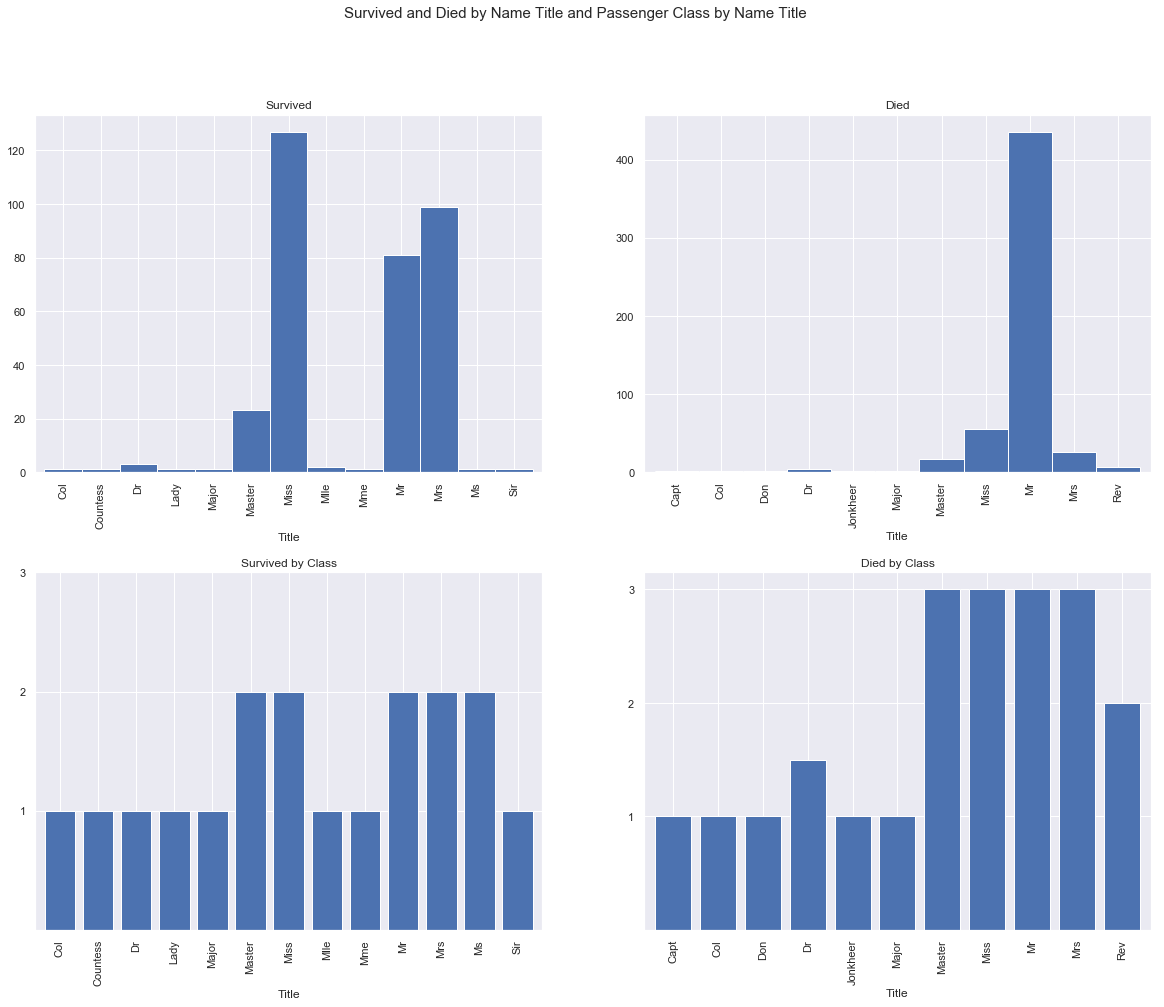

In [265]:
# Plot of those survived and died by name title and passenger class
fig, axes = plt.subplots(2, 2)
by_title_surv_stats['Count'].plot(kind='bar', width=1, figsize=(20, 15), ax=axes[0,0], title='Survived')
by_title_died_stats['Count'].plot(kind='bar', width=1, figsize=(20, 15), ax=axes[0,1],  title='Died')
by_title_surv_stats['Pclass'].plot(kind='bar', width=0.8, figsize=(20, 15), ax=axes[1,0], yticks=[1,2,3], 
                                   title='Survived by Class')
by_title_died_stats['Pclass'].plot(kind='bar', width=0.8, figsize=(20, 15), ax=axes[1,1], yticks=[1,2,3], 
                                   title='Died by Class')
plt.subplots_adjust(hspace=0.28)
plt.suptitle('Survived and Died by Name Title and Passenger Class by Name Title', fontsize='15')
plt.savefig('Survived and Died by Name Title and Passenger Class by Name Title')
plt.show();

### Plot of Passengers That Survived or Died by Age Group in Percentages:
 - The highest percentage of those that died were in the 30 to 35 age group which also happens to coincide with the median age of males with the name title Mr. with a total of 517 passengers with that name title.

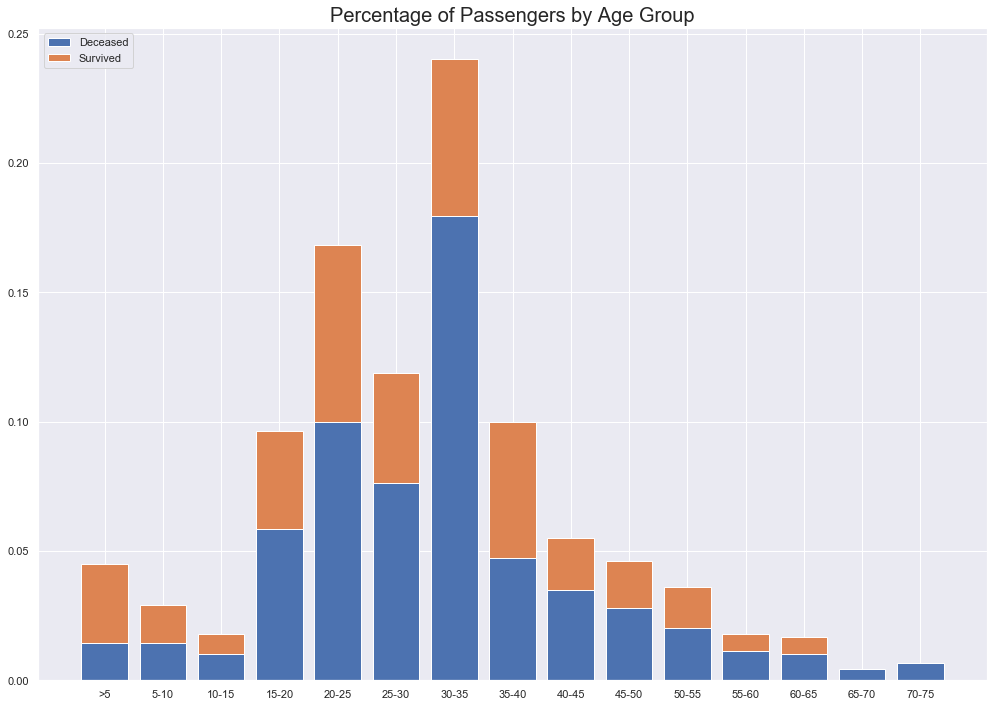

In [266]:
age_groups = by_title.Age // 5 + 1
age_groups.fillna(0, inplace=True)

num_people = by_title.shape[0]
deceased_age_group = age_groups[by_title.Survived==0].value_counts()
survived_age_group = age_groups[by_title.Survived==1].value_counts()
width = 0.8


inds = np.sort(deceased_age_group.index.values)
plt.figure(figsize=(17, 12))

age_groups_deceased_bar = plt.bar(inds, deceased_age_group[inds].values / num_people, width)
age_groups_survived_bar = plt.bar(inds, survived_age_group[inds].values / num_people, width,
                                  bottom=deceased_age_group[inds].values / num_people)

plt.title('Percentage of Passengers by Age Group', fontdict={'fontsize':20})

age_groups_ticks = ['>5'] + ['{}-{}'.format(int(i * 5), int((i + 1)* 5)) for i in inds[0:]]

plt.xticks(inds, age_groups_ticks)
plt.legend((age_groups_deceased_bar[0], age_groups_survived_bar[0]), ('Deceased', 'Survived'))

plt.savefig('percenage of passenger age')
plt.show()

#### Interesting fact to see that passengers less than 15 years old had over a 50% chance of survival:

In [267]:
by_title[by_title.Age <= 15].Survived.value_counts(normalize=True)

1   0.586
0   0.414
Name: Survived, dtype: float64

### Label Encode Some Features:
 - For further plotting and data preparation (down below), gender and embarked are label encoded.

In [268]:
#Label encode certain features for density plots
from sklearn.preprocessing import LabelEncoder
columns = ('Embarked', 'Sex')

# Apply LabelEncoder to categorical features
for c in columns:
    lbl = LabelEncoder() 
    lbl.fit(list(by_title[c].values)) 
    by_title[c] = lbl.transform(list(by_title[c].values))

#Check Data
by_title[['Embarked', 'Sex']].head()

,Embarked,Sex
1,0,0
3,2,0
6,2,1
11,2,0
23,2,1


### Plot of Passengers That Survived of Died by Gender in Percentages:
 - The proportion of females to males survived were much higher.

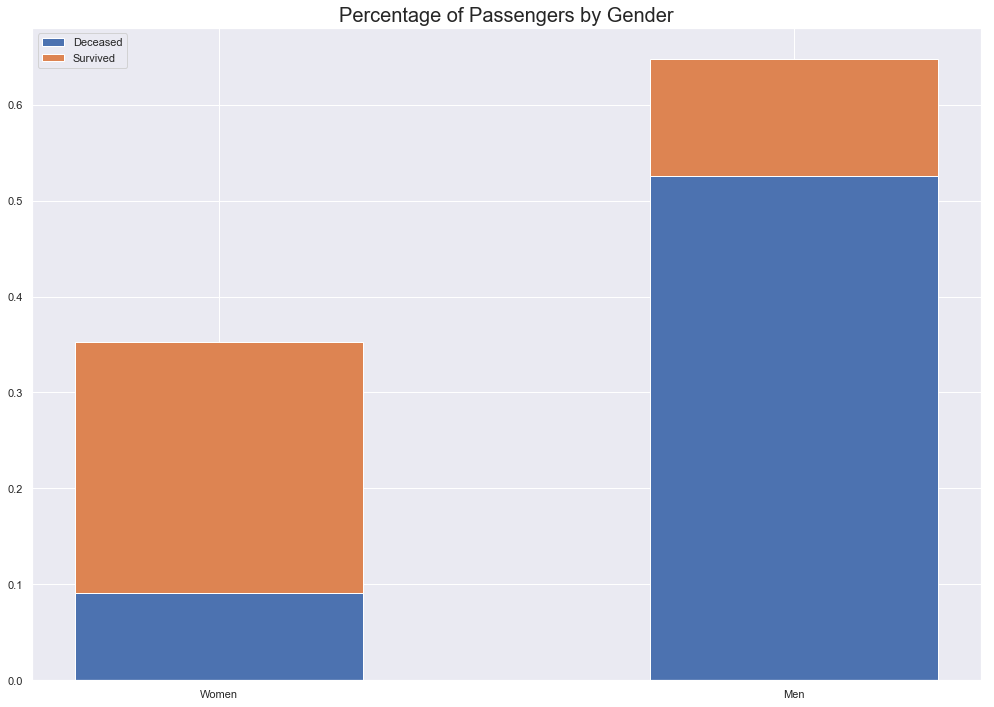

In [269]:
# Plot of percentage of passengers
num_people = by_title.shape[0]
deceased_gender = by_title.Sex[by_title.Survived==0].value_counts()
survived_gender = by_title.Sex[by_title.Survived==1].value_counts()


inds = [1, 0]

plt.figure(figsize=(17, 12))

male_plt = plt.bar(inds, deceased_gender.values / num_people, width=0.5)
female_plt = plt.bar(inds, survived_gender[inds].values / num_people,
                     width=0.5, bottom=deceased_gender[inds].values / num_people)

plt.title('Percentage of Passengers by Gender', fontdict={'fontsize':20})

plt.xticks(inds, ('Men', 'Women'))
plt.legend((male_plt[0], female_plt[0]), ('Deceased', 'Survived'))

plt.savefig('percentage by gender')
plt.show()

#### Looking at the actual percentages shows the significant difference: 

In [270]:
#Percentage Survived and Deaths
print('Male Survived/Deaths by Percentage:')
print(by_title[by_title.Sex == 1].Survived.value_counts(normalize=True))
print('-'*40)
print('Female Survived/Deaths by Percentage:')
print(by_title[by_title.Sex == 0].Survived.value_counts(normalize=True))

Male Survived/Deaths by Percentage:
0   0.811
1   0.189
Name: Survived, dtype: float64
----------------------------------------
Female Survived/Deaths by Percentage:
1   0.742
0   0.258
Name: Survived, dtype: float64


### Plot of Passengers Survived or Died by Passenger Class in Percentages:
 - First and second class were definitely good indicators of a survival characteristic

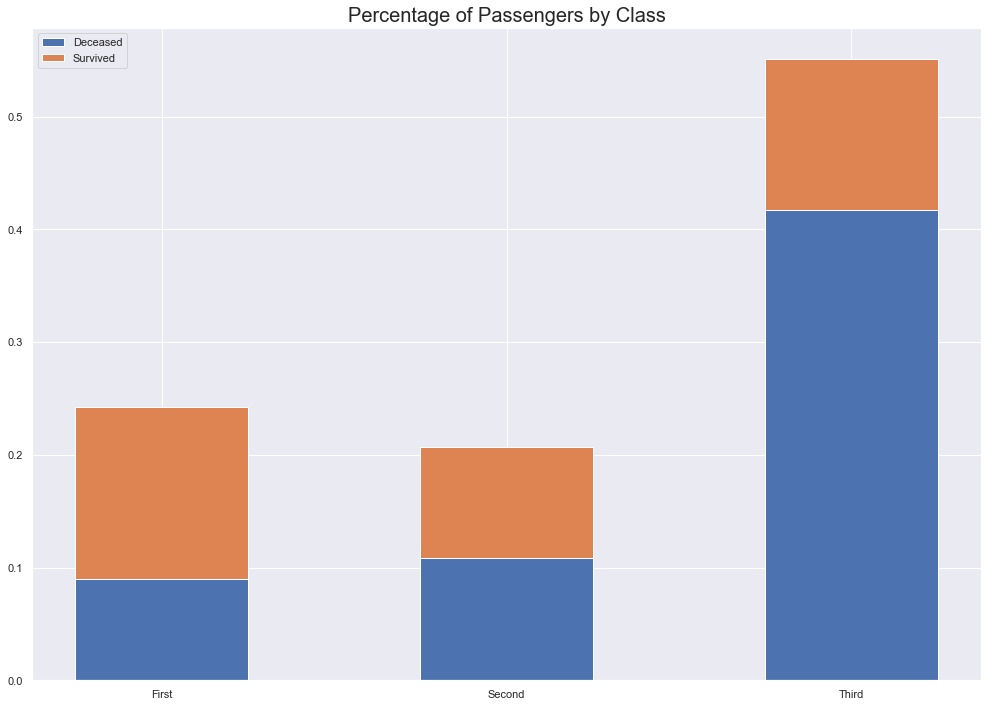

In [271]:
#Plot of passengers survived or died by passenger class by percentage
deceased_class = by_title.Pclass[by_title.Survived==0].value_counts()
survived_class = by_title.Pclass[by_title.Survived==1].value_counts()


inds = [1, 2, 3]

plt.figure(figsize=(17, 12))

class_d_plt = plt.bar(inds, deceased_class[inds].values / num_people, width=0.5)
class_s_plt = plt.bar(inds, survived_class[inds].values / num_people,
                     width=0.5, bottom=deceased_class[inds].values / num_people)

plt.title('Percentage of Passengers by Class', fontdict={'fontsize':20})

plt.xticks(inds, ('First', 'Second', 'Third'))
plt.legend((male_plt[0], female_plt[0]), ('Deceased', 'Survived'))

plt.savefig('percent by class')
plt.show()

#### Survival by looking at actual percentages show the significant differences as well.

In [272]:
by_title.groupby('Pclass').Survived.value_counts(normalize=True, sort=False)

Pclass  Survived
1       0          0.370
        1          0.630
2       0          0.527
        1          0.473
3       0          0.758
        1          0.242
Name: Survived, dtype: float64

### Plot of Survived or Died by Port of Embarkation:
 - It seems that proportionally that many more passengers perished that embarked from Southhampton. Yet the figures are definitely skewed. 

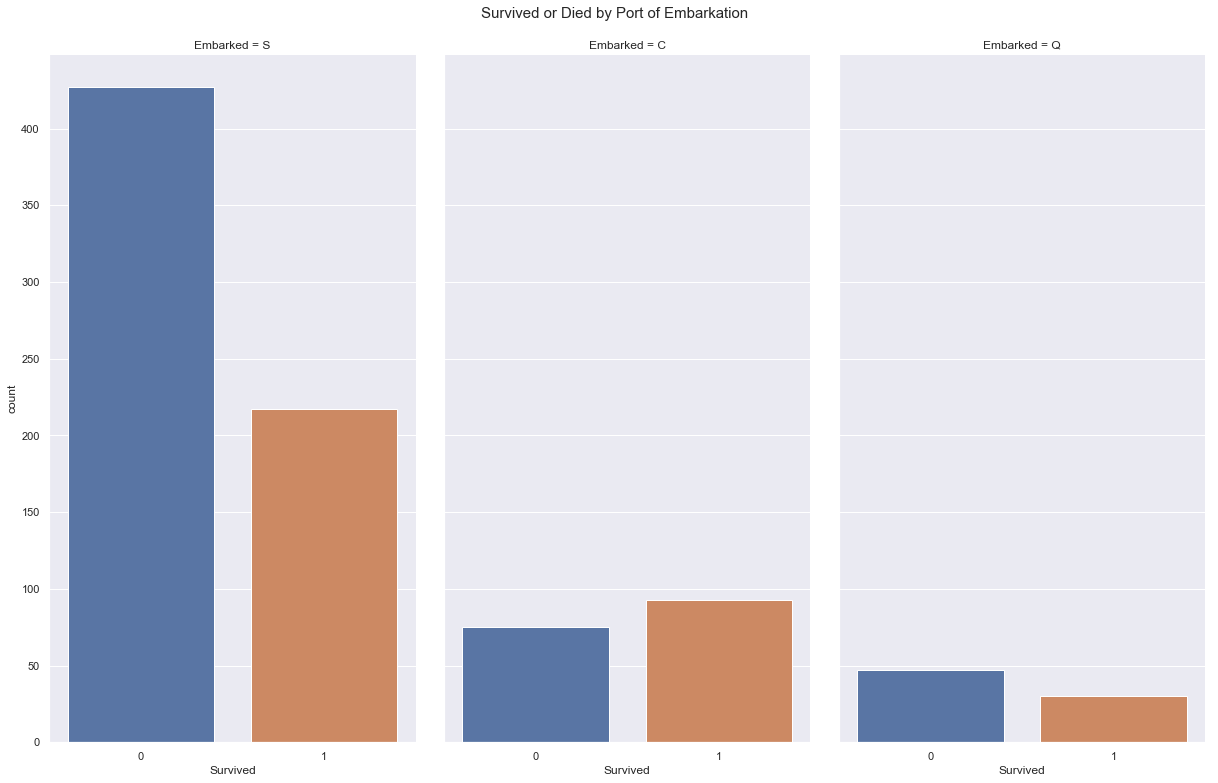

In [273]:
# Plot of survived or died by embarked
factor = sns.factorplot(x='Survived', col='Embarked', kind='count', data=train);
factor.fig.set_size_inches(17,12);
plt.suptitle('Survived or Died by Port of Embarkation', fontsize='15')
plt.savefig('embarked')
plt.show();

### Histogram of Fares by Survived or Died:
 - Seems that those that paid more had a higher chance of surviving.
 - Mean fare of survived was 48.39, and died was 22.11.

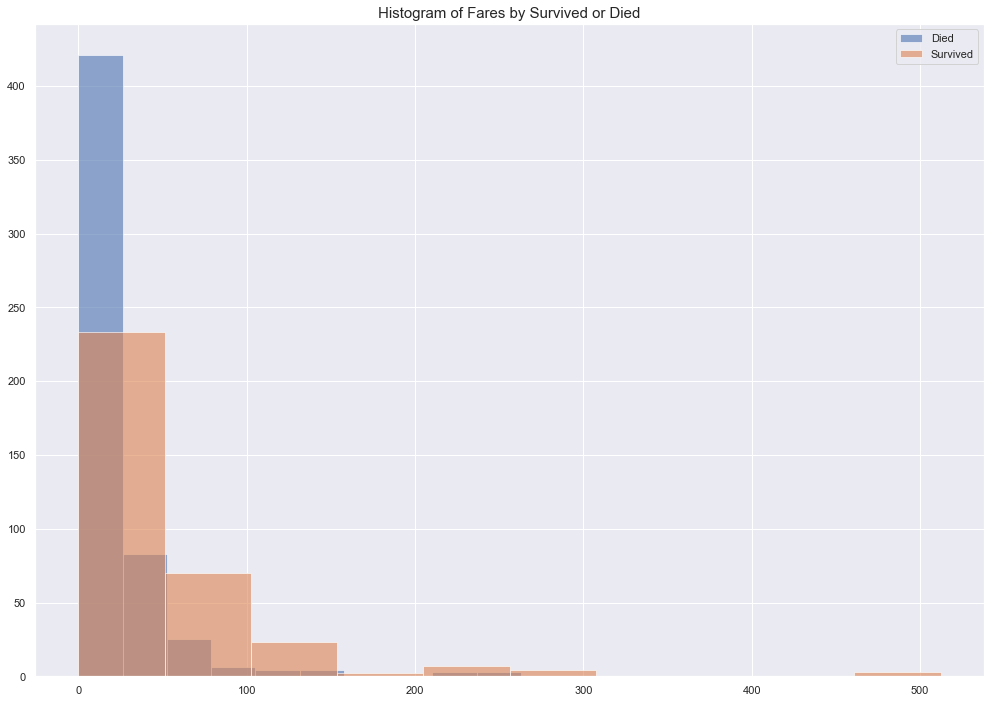

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
Survived,,,,,,,,
0,2.532,0.852,30.626,0.554,0.330,22.118,1.641,5.472
1,1.950,0.319,28.262,0.474,0.465,48.395,1.368,4.675


In [274]:
#Histogram of fare by survived
fig, ax = plt.subplots()
by_title.groupby('Survived').Fare.hist(alpha=0.6, figsize=(17,12), ax=ax);
ax.legend(['Died', 'Survived'])
plt.title('Histogram of Fares by Survived or Died', fontsize='15')
plt.savefig('fares by survived')
plt.show();
#Mean statistics
by_title.groupby('Survived').mean()

### To Get a Picture of the Difference in Survival by Fare, A Swarm Plot Give a Good Visualization:
 - Fare seemd to have been definitely correlated with survival aboard the Titanic.

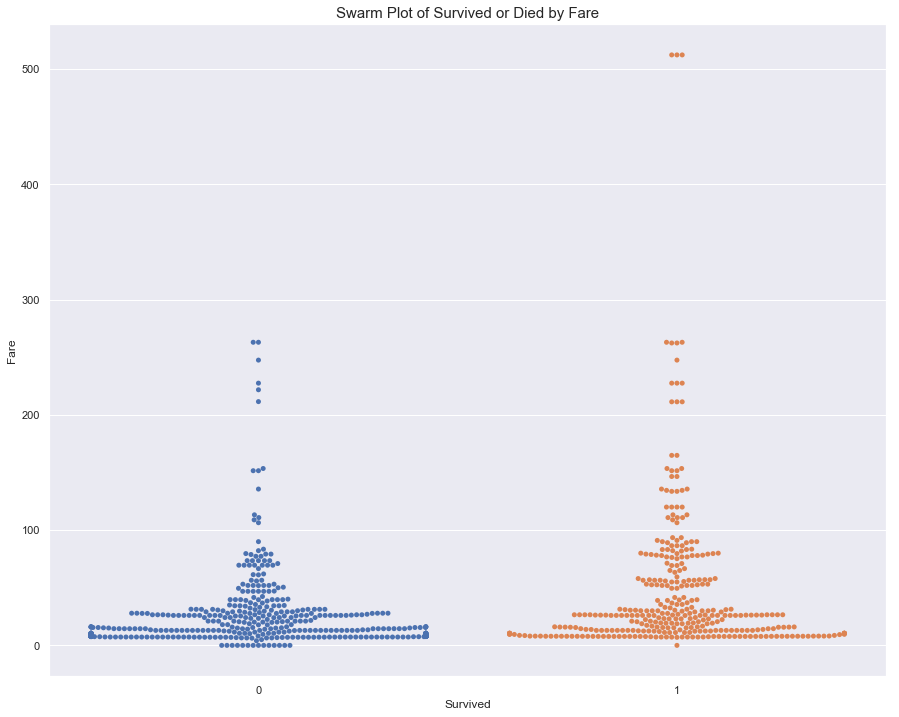

In [275]:
#Swarm plot of fares by survived or died
sns.set(rc={'figure.figsize':(15, 12)})
swarm = sns.swarmplot(x='Survived', y='Fare', data=by_title)
plt.title('Swarm Plot of Survived or Died by Fare', fontsize='15')
plt.savefig('swarmplotfare')
plt.show();

### Scatterplot matrix of Characteristics in Titanic Based off of Survival:
 - The scatter plot matrix shows that most relationships among characteristics were correlated with survival. Examples are higher passenger class led to higher proportional survival rates, lower ages had higher proportions of survival, and upper decks had higher proportions of survival.

D:\python3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\python3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


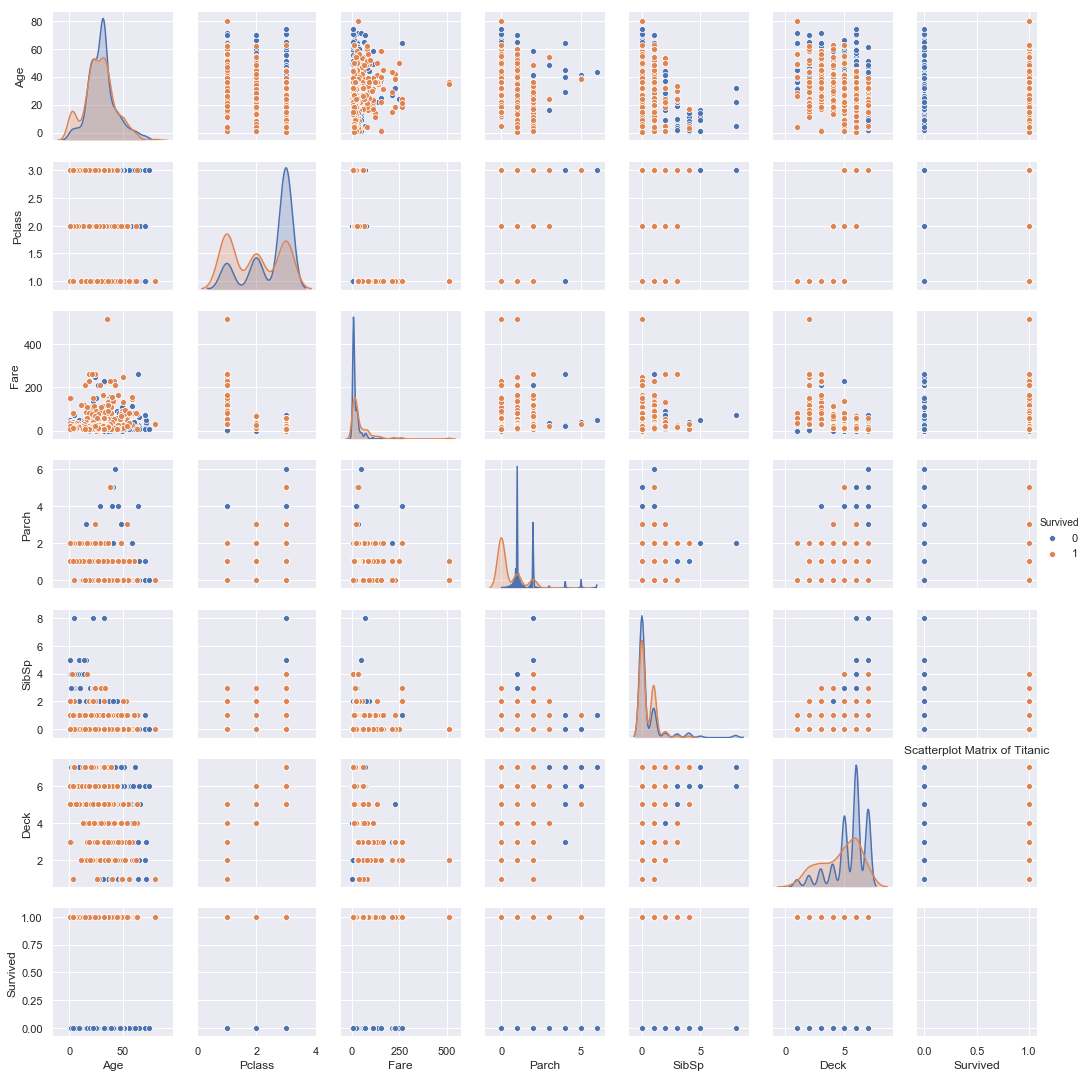

In [276]:
#Scatterplot matrix
pair_plot = sns.pairplot(by_title[['Age', 'Pclass', 'Fare', 'Parch', 'SibSp', 'Deck', 'Survived']], hue='Survived');
pair_plot.fig.set_size_inches(15,15)
plt.title('Scatterplot Matrix of Titanic')
plt.savefig('scatterplotmatrix')
plt.show();

### Density Plots:
 - Density plots show a bit of right skewing with the attribute: age. This is further examined later on where they were binned and categorized, yet the shape of the distribution was almost preserved.
 - Passenger class looks like it can be dichotomized.
 - Fares are highly skewed to the right. This is also addressed in data preparation.
 - Parents and children, and siblings and spouses were also addressed.
 - Embarked was not dichotomized, as it performed worse in validation.
 - Decks were left unchanged.

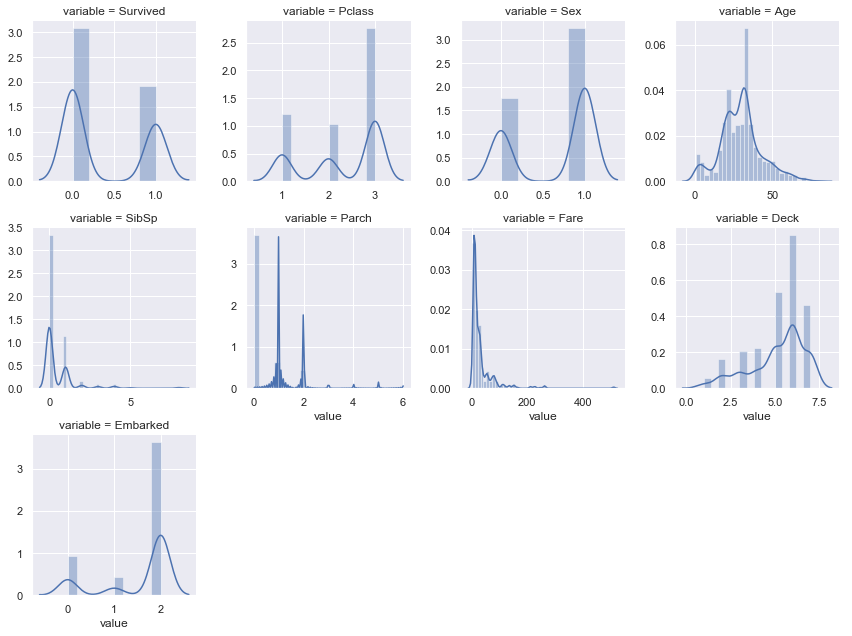

In [277]:
#Density plots for features
#Define function to plot data
def hist_density_plots(data, features):
    d = data
    f = features
    g = pd.melt(d, value_vars = f)
    gm = sns.FacetGrid(g, col='variable', col_wrap = 4, sharex = False, sharey = False)
    gm = gm.map(sns.distplot, 'value')
    sns.set(rc={'figure.figsize':(20,15)})
    plt.savefig('Density Plots')
    plt.show;
    return
  
#Density plots
hist_density_plots(by_title.dropna(), 
                   ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Deck', 'Embarked'])

### Box Plots:
 - Box plots show that age has some outliers. This was addressed where they were binned and categorized.
 - Fare also has outliers that affect the distribution. This was also addressed.
 - Again parents and children, and siblings and spouses have significant outliers. This was further addressed, but outliers were not eliminated. Additionally, it is apparent that parents and children had more extreme outliers than siblings and spouses.

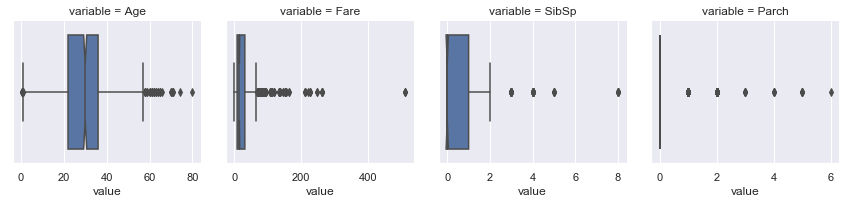

In [278]:
#Box plots for features
#Boxplot function to plot data
def box_plot(data, features):
    d = data
    f = features
    g = pd.melt(d, value_vars = f)
    gm = sns.FacetGrid(g, col='variable', col_wrap = 4, sharex = False, sharey = False)
    gm = gm.map(sns.boxplot, 'value', notch=True)
    sns.set(rc={'figure.figsize':(20,15)})
    plt.savefig('Boxplots')
    plt.show;

#Boxplots
box_plot(by_title, ['Age', 'Fare', 'SibSp', 'Parch'])

### Extreme Outliers:
 - As shown in the boxplots there are a number of extreme outliers for parents and children. These were not eliminated.
 - Fares were addressed where they were binned and categorized, and then transformed into dichotomous variables.
 - Siblings and spouses were also addressed.
 - Age had only 1 extreme upper value. Therefore, no ages were eliminated.

In [279]:
#Check for extreme outliers
def extreme_outliers(dataframe):
    #Get numeric data
    outliers = dataframe._get_numeric_data()

    #Get the IQR
    q1 = outliers.quantile(0.25)
    q3 = outliers.quantile(0.75)
    iqr = q3 - q1

    #Calculate and total extreme outliers (lower and upper bounds)
    extreme_lower = (q1 - 3 * iqr)
    extreme_upper = (q3 + 3 * iqr)
    extreme_lower =(outliers < extreme_lower).sum()
    extreme_upper = (outliers > extreme_upper).sum()

    #Organize and show in table
    extreme_lower= pd.DataFrame(extreme_lower, columns=['Extreme_Lower'])
    extreme_upper = pd.DataFrame(extreme_upper, columns=['Extreme_Upper'])
    extreme_outliers = extreme_lower.merge(extreme_upper, left_index=True, right_index=True)
    return extreme_outliers.sort_values(by='Extreme_Upper', ascending=False).head(4)

extreme_outliers(by_title)

,Extreme_Lower,Extreme_Upper
Parch,0,213
Fare,0,53
SibSp,0,12
Age,0,1


## Data Preparation:
 - Data was prepared with the preprocessed data above used for exploration and visualization.
 - Data was merged with test set and further processed for uniformity.

### Training set:
 - A lot of data was prepared with data exploration and visualization so a new dataframe was used for the training set to retain the the original training data and the dataframe used for visualization.

In [280]:
#A lot of data was prepared with the data visualization so a new dataframe was used for the training set to retain the
#the original training data and the dataframe used for visualization
train_df = by_title.copy().sort_index()
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,0,3,"Braund, Mr. Owen Harris",1,22.000,1,0,A/5 21171,7.250,U0,2,Mr,6
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000,1,0,PC 17599,71.283,C85,0,Mrs,3
2,1,3,"Heikkinen, Miss. Laina",0,26.000,0,0,STON/O2. 3101282,7.925,U0,2,Miss,6
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000,1,0,113803,53.100,C123,2,Mrs,3
4,0,3,"Allen, Mr. William Henry",1,35.000,0,0,373450,8.050,U0,2,Mr,6


### Test Data Processing:
 - A copy of the test data was made in case the original test data was needed later on.

In [281]:
test_df = test.copy()

### Create Deck Categories by Cabin Letter:
 - As in preparation, the same method is used here. The imputations are employed later below so that the random choice generator has more data to choose from. Again this is usually not recommended with sparse data.

In [282]:
#Create Deck Categories by Cabin Letter:
deck = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 1}
for i in test_df:
    test_df['Cabin'] = test_df['Cabin'].fillna('U0')
    test_df['Deck'] = test_df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    test_df['Deck'] = test_df['Deck'].map(deck)

### Feature Label Encoding:
 - For uniformity with training data.

In [283]:
#Label encode features for uniformity
columns = ('Embarked', 'Sex')

# Apply LabelEncoder to categorical features
for c in columns:
    lbl = LabelEncoder() 
    lbl.fit(list(test_df[c].values)) 
    test_df[c] = lbl.transform(list(test_df[c].values))

#Check Data
test_df[['Embarked', 'Sex']].head()

,Embarked,Sex
0,1,1
1,2,0
2,1,1
3,2,1
4,2,0


### Merge All Data for Processing:
 - Data is merged for further processing with test data. 

In [284]:
#Merge data and store survived in another variable
atrain = train_df.shape[0]
atest = test_df.shape[0]
y_train = train_df.Survived.values
data = pd.concat([train_df, test_df]).reset_index(drop=True)
data.drop(['Survived'], axis=1, inplace=True)
print('Data size is: {}'.format(data.shape))

Data size is: (1309, 12)


### Impute Missing Values:

In [285]:
#Number and percentage of values missing:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Title,418,31.900
Deck,327,25.000
Age,86,6.600
Fare,1,0.100
Ticket,0,0.000


### Fill NA with Deck Number Using Random Choice Generator:
 - Deck number was not imputed with training data before in the hopes that there was an even distribution with the random choice method that was used.
 - Validation data (not in this appendix but can be provided) showed that this performed better than imputing decks with 0.
 - Percentage distribution by deck shows that they are somewhat close to the figures computed previously.

In [286]:
class_1 = data.loc[data['Pclass']==1]
class_1 = fill_with_random(class_1, 'Deck')
pd.DataFrame(class_1['Deck'].value_counts()/class_1['Deck'].count().sum()).sort_index()

,Deck
1.000,0.090
2.000,0.269
3.000,0.362
4.000,0.149
5.000,0.130


In [287]:
class_2 = data.loc[data['Pclass']==2]
class_2 = fill_with_random(class_2, 'Deck')
pd.DataFrame(class_2['Deck'].value_counts()/class_2['Deck'].count().sum()).sort_index()

,Deck
4.000,0.249
5.000,0.256
6.000,0.495


In [288]:
class_3 = data.loc[data['Pclass']==3]
class_3 = fill_with_random(class_3, 'Deck')
pd.DataFrame(class_3['Deck'].value_counts()/class_3['Deck'].count().sum()).sort_index()

,Deck
5.000,0.221
6.000,0.427
7.000,0.351


In [289]:
data = pd.concat([class_1, class_2, class_3])
data['Deck'] = data['Deck'].astype(int)
data.Deck.isnull().sum()

0

### Impute Age with Mean by Title:

In [290]:
#Imputing age with mean age by title
title = data['Name'].str.extract(r'\b(\w+)\.') #getting ranks using regex
data['Title'] = title
title_mean = dict(round(data['Age'].groupby(data['Title']).mean()))

fill_func = lambda g: g.fillna(title_mean[g.name])
mean_missing_age_by_title = data['Age'].groupby(data['Title']).apply(fill_func)
data['Age'] = mean_missing_age_by_title
data.Age.isnull().sum()

0

### Impute Fare with Mean by Passenger Class:
 - There was only one fare that was missing so it is reasonable to impute this value with the mean by class.

In [291]:
#Impute fare with mean by passenger class
data['Fare'] = data.groupby("Pclass")['Fare'].transform(
    lambda x: x.fillna(x.mean()))

### Check for NA Values:

In [292]:
data.isnull().sum()

Age         0
Cabin       0
Deck        0
Embarked    0
Fare        0
Name        0
Parch       0
Pclass      0
Sex         0
SibSp       0
Ticket      0
Title       0
dtype: int64

### Transform Data Types that are Float to Integer:
 - This was needed for further preparation.

In [293]:
#Check data types
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1308
Data columns (total 12 columns):
Age         1309 non-null float64
Cabin       1309 non-null object
Deck        1309 non-null int32
Embarked    1309 non-null int64
Fare        1309 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null int64
SibSp       1309 non-null int64
Ticket      1309 non-null object
Title       1309 non-null object
dtypes: float64(2), int32(1), int64(5), object(4)
memory usage: 167.8+ KB


In [294]:
# Transform data types to integer
data['Age'] = data['Age'].astype('int64')
data['Fare'] = data['Fare'].astype('int64')
data['Deck'] = data['Deck'].astype('int64')

### Create Categories and Additional Variables:

### Split Age into Bins and Categorize:
 - Binning and categorizing age helped in the classification process. Yet they were not transformed into dichotomous variables, as it affected validation testing.

#### First Check the Distribution:
 - It is a bit skewed to the right.
 - Kurtosis is a little high but acceptable
 - Age does not seem that it needs to be transformed, but will be to make classification easier.

mu = 29.84 and sigma = 13.19
Kurtosis = 3.68 and Skewness = 0.38


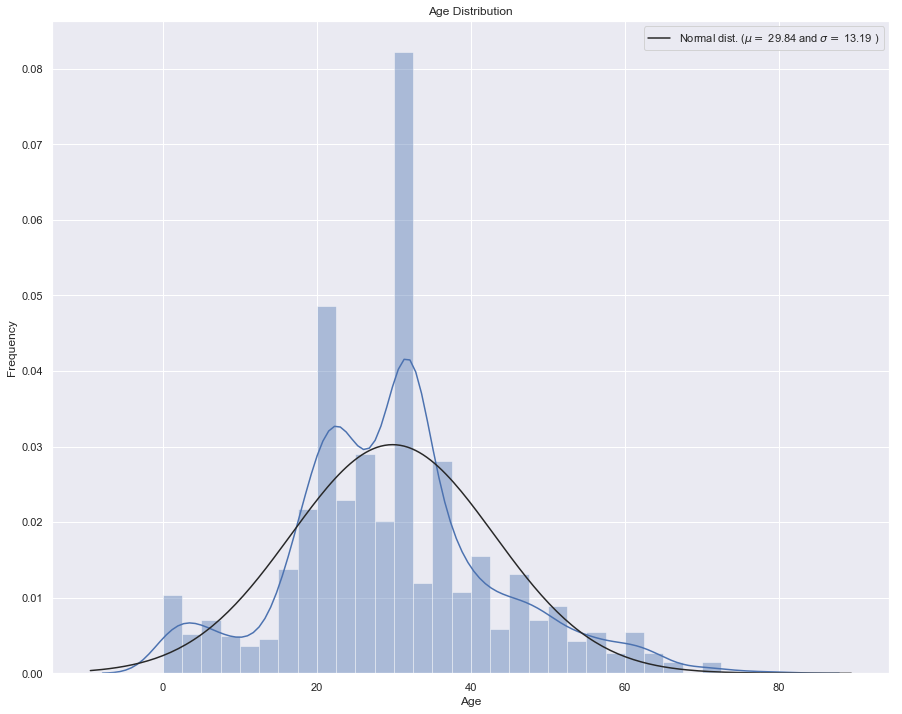

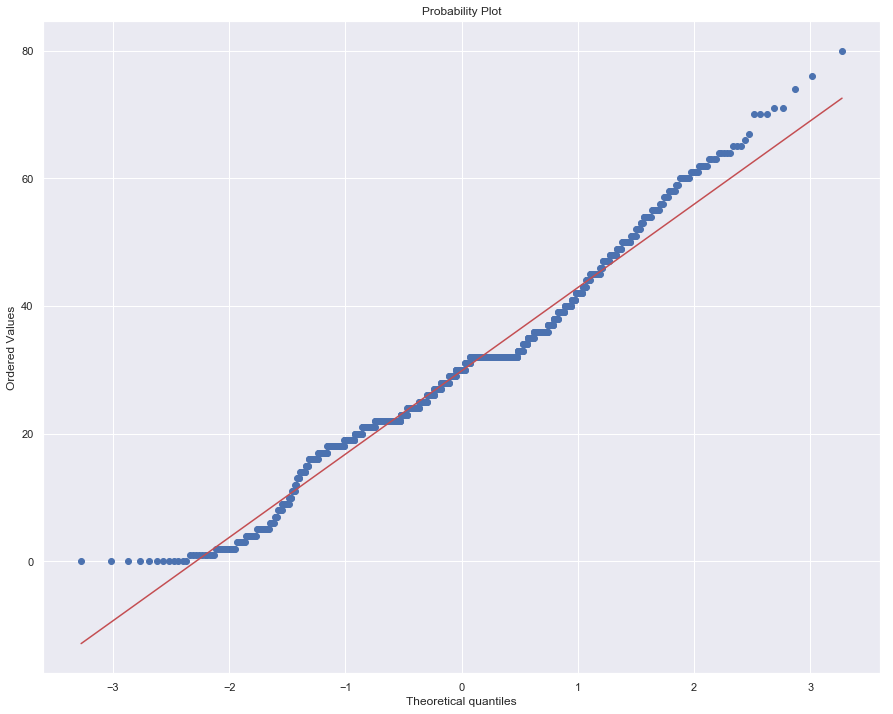

In [295]:
#Fitted parameters for distribution
(mu, sigma) = norm.fit(data['Age'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
kurt = kurtosis(data['Age'], fisher=False)
skewness = skew(data['Age'])
print('Kurtosis = {:.2f} and Skewness = {:.2f}'.format(kurt, skewness))

#Plot the distribution
sns.set(rc={'figure.figsize':(15, 12)})
sns.distplot(data['Age'], fit=norm);
sns.set(rc={'figure.figsize':(15, 12)})
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.savefig('Age distribution')

#Plot the QQ-plot
fig = plt.figure()
qqplot = stats.probplot(data['Age'], plot=plt)
plt.savefig('Age distribution QQ')
plt.show()

#### Split into Bins:
 - Age were based off of these quantiles (0.08, 0.16, 0.24, 0.42, 0.69, 0.82, 0.99) which somewhat gave an even distribution.

In [296]:
data.loc[data['Age'] <= 11, 'Age'] = 0
data.loc[(data['Age'] > 11) & (data['Age'] <= 18), 'Age'] = 1
data.loc[(data['Age'] > 18) & (data['Age'] <= 22), 'Age'] = 2
data.loc[(data['Age'] > 22) & (data['Age'] <= 27), 'Age'] = 3
data.loc[(data['Age'] > 27) & (data['Age'] <= 33), 'Age'] = 4
data.loc[(data['Age'] > 33) & (data['Age'] <= 40), 'Age'] = 5
data.loc[(data['Age'] > 40) & (data['Age'] <= 66), 'Age'] = 6
data.loc[data['Age'] > 66, 'Age'] = 6
data.Age.value_counts()

4    356
6    225
2    188
3    170
5    166
1    105
0     99
Name: Age, dtype: int64

#### Checking the Distribution Once More:
 - Though skewness is to the left now the shape of the distibution seems a bit smoother.
 - Kurtosis was affected. However, it seems that the standard deviation has improved.
 - It seems that either binning or leaving it alone is not as significant. Yet it was helpful in modeling.

mu = 3.51 and sigma = 1.79
Kurtosis = 2.20 and Skewness = -0.34


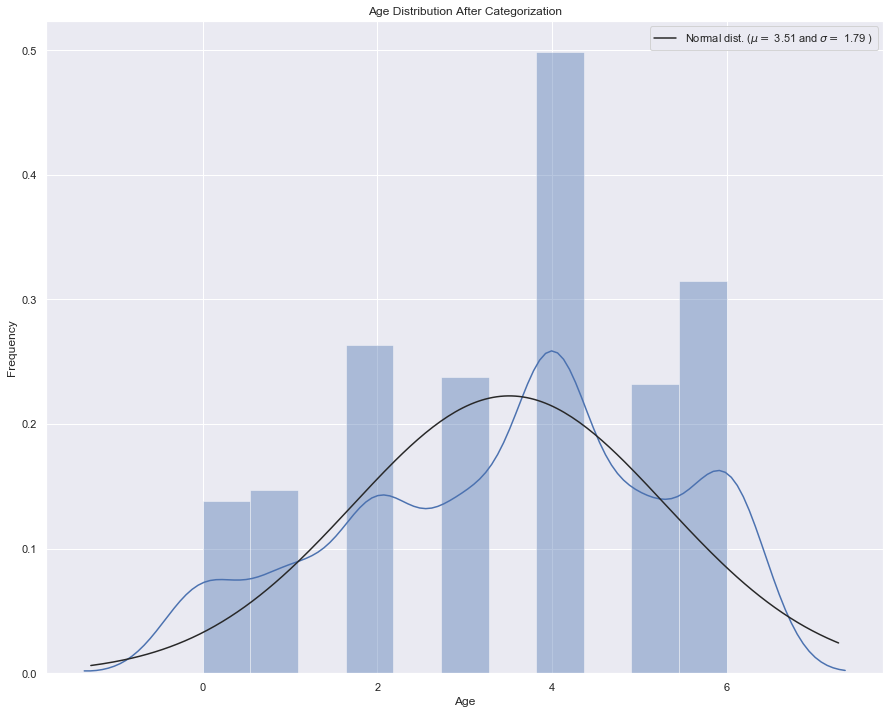

In [297]:
#Fitted parameters for distribution
(mu, sigma) = norm.fit(data['Age'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
kurt = kurtosis(data['Age'], fisher=False)
skewness = skew(data['Age'])
print('Kurtosis = {:.2f} and Skewness = {:.2f}'.format(kurt, skewness))

#Plot the distribution
sns.set(rc={'figure.figsize':(15, 12)})
sns.distplot(data['Age'], fit=norm);
sns.set(rc={'figure.figsize':(15, 12)})
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Age Distribution After Categorization')
plt.savefig('Age distribution after categorization')
plt.show();

### Fares Split Into Categories:
 - Fares were highly skewed to the right with very high kurtosis.
 - It was imperative that this issue was addressed.

#### First Check the Distribution:

mu = 32.85 and sigma = 51.73
Kurtosis = 29.95 and Skewness = 4.36


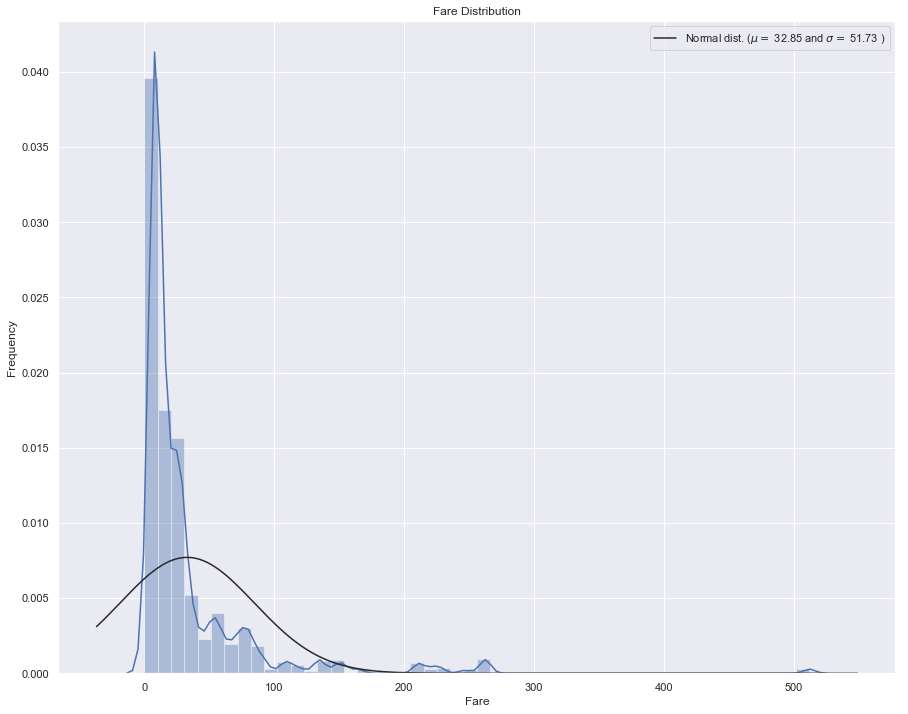

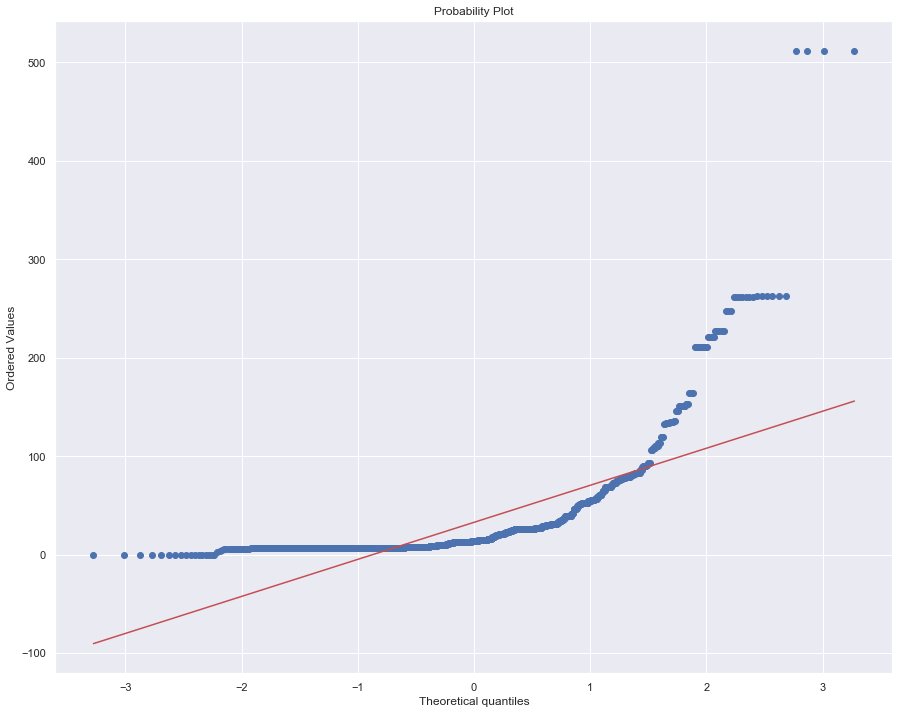

In [298]:
#Fitted parameters for distribution
(mu, sigma) = norm.fit(data['Fare'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
kurt = kurtosis(data['Fare'], fisher=False)
skewness = skew(data['Fare'])
print('Kurtosis = {:.2f} and Skewness = {:.2f}'.format(kurt, skewness))

#Plot the distribution
sns.set(rc={'figure.figsize':(15, 12)})
sns.distplot(data['Fare'], fit=norm);
sns.set(rc={'figure.figsize':(15, 12)})
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Fare Distribution')
plt.savefig('Fare distribution')

#Plot the QQ-plot
fig = plt.figure()
qqplot = stats.probplot(data['Fare'], plot=plt)
plt.savefig('Fare distribution QQ')
plt.show()

#### Split Fares Into Categories:
 - Fares were split based off of quantiles (0.25, 0.5, 0.75, 0.95, 0.99) with a little modification to have a somewhat even distribution.

In [299]:
data.loc[data['Fare'] <= 7.91, 'Fare'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[(data['Fare'] > 31) & (data['Fare'] <= 99), 'Fare']   = 3
data.loc[(data['Fare'] > 99) & (data['Fare'] <= 250), 'Fare']   = 4
data.loc[ data['Fare'] > 250, 'Fare'] = 5
data.Fare.value_counts()

0    360
2    325
1    313
3    227
4     67
5     17
Name: Fare, dtype: int64

#### Checking the Distribution Once More:
 - Although it is still skewed to the right it has improved significantly. This should be maintained relative to survival rates by class.
 - Kurtosis has improved significantly.
 - Fares can be split into dichotomous variables.

mu = 1.53 and sigma = 1.27
Kurtosis = 2.38 and Skewness = 0.44


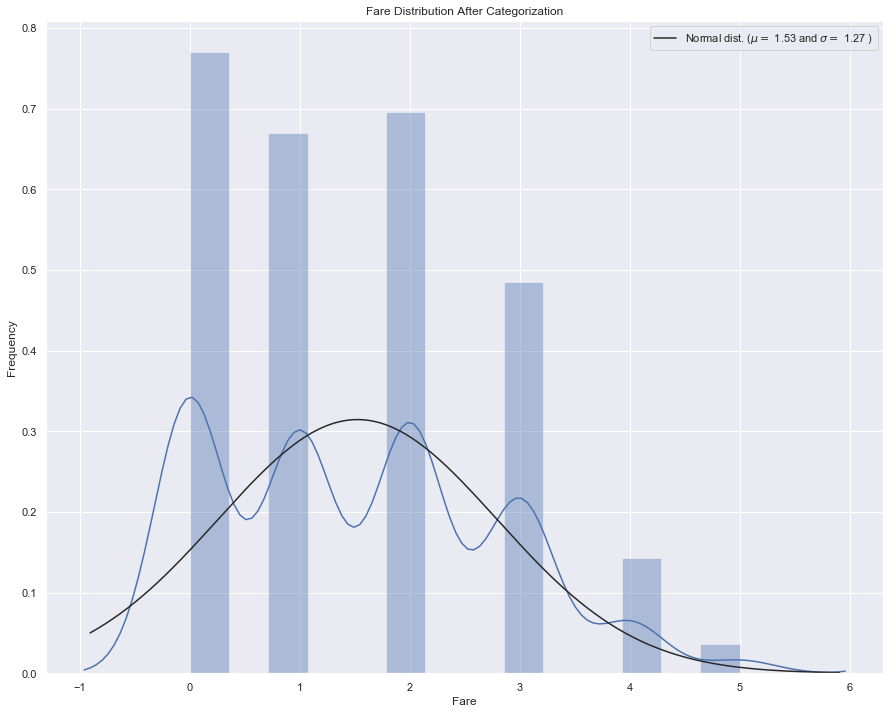

In [300]:
#Fitted parameters for distribution
(mu, sigma) = norm.fit(data['Fare'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
kurt = kurtosis(data['Fare'], fisher=False)
skewness = skew(data['Fare'])
print('Kurtosis = {:.2f} and Skewness = {:.2f}'.format(kurt, skewness))

#Plot the distribution
sns.set(rc={'figure.figsize':(15, 12)})
sns.distplot(data['Fare'], fit=norm);
sns.set(rc={'figure.figsize':(15, 12)})
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Fare Distribution After Categorization')
plt.savefig('Fare distribution after categorization')
plt.show();

### Additional Variables:

### Number of Relatives:
 - This includes siblings and spouses, and parents and children.
 - These variables are dropped below that possibly helps with extreme outliers present in parents and children variable.

In [301]:
data['Relatives'] = data['SibSp'] + data['Parch']

### Age Times Passenger Class:
 - Interaction effect will be evaluated and added as an interaction term if it is significant in relation to survived.

In [302]:
#Checking if interaction can be added for Age and Class
data = data.sort_index()
train_data = data[:atrain]
train_data['Survived'] = train_df['Survived']
anova = ols('Survived ~ C(Age)*C(Pclass)', train_data).fit()
sm.stats.anova_lm(anova, typ= 2)

,sum_sq,df,F,PR(>F)
C(Age),11.518,6.000,9.809,0.000
C(Pclass),27.757,2.000,70.914,0.000
C(Age):C(Pclass),4.609,12.000,1.962,0.025
Residual,170.267,870.000,nan,nan


#### With a P-value of 0.025 Age * Pclass seem to have an interaction effect that is significant. Therefore, interaction term is added.

In [303]:
data['Age_Class'] = data['Age']*data['Pclass']

### Fare Per Person:
 - Computing fare by the number of relatives traveling together seemed to help the model a little more. Therefore, this was added.

In [304]:
data['Fare_Per_Person'] = data['Fare']/(data['Relatives']+1)
data['Fare_Per_Person'] = data['Fare_Per_Person'].astype('int64')

### Additional Data Cleaning:

### Drop Variables That Are Not Needed:
 - Name, ticket, cabin are not necessary as they cannot be converted to useful categories, they will add noise, and do not seem to add value to the model.
 - Since there are already number of relatives, parents and children, and siblings and spouses are dropped. For some reason these variables did not matter when logistic regression and naive bayes were used. Additionally, the extreme outliers by dropping parents and children are smaller when combined with siblings and spouses, as shown below.

In [305]:
#Extreme Outliers Relatives
df = by_title.copy()
df['Relatives'] = df['SibSp'] + df['Parch']
df = df.drop(columns=['Fare', 'SibSp', 'Parch'])
extreme_outliers(df)

,Extreme_Lower,Extreme_Upper
Relatives,0,47
Age,0,1
Survived,0,0
Pclass,0,0


In [306]:
#Drop variables that do not hold additional value to the analysis
data = data.drop(['Name', 'Ticket', 'Cabin', 'Parch', 'SibSp'], axis=1)

### Combine Titles That are Similar:
 - Mlle and Ms are same are same as Miss
 - All other titles are of stature or nobility. These are split between females and males (most males of this category died while a small number, females survived).

In [307]:
#Combine titles of similarity
data.loc[data['Title'] == 'Mlle', 'Title'] = 'Miss'
data.loc[data['Title'] == 'Ms', 'Title'] = 'Miss'
data.loc[data['Title'] == 'Mme', 'Title'] = 'Female Noble'
data.loc[data['Title'] == 'Lady', 'Title'] = 'Female Noble'
data.loc[data['Title'] == 'Countess', 'Title'] = 'Female Noble'
data.loc[data['Title'] == 'Dona', 'Title'] = 'Female Noble'
data.loc[data['Title'] == 'Capt', 'Title'] = 'Male Noble'
data.loc[data['Title'] == 'Col', 'Title'] = 'Male Noble'
data.loc[data['Title'] == 'Don', 'Title'] = 'Male Noble'
data.loc[data['Title'] == 'Major', 'Title'] = 'Male Noble'
data.loc[data['Title'] == 'Jonkheer', 'Title'] = 'Male Noble'
data.loc[data['Title'] == 'Sir', 'Title'] = 'Male Noble'

### Dummy variables (Dichotomous Variables) Created for Passenger Class, Fare, and Title:
 - Other dummy variables could have been made with other categories such as embarked, but they did not score well in validation. It seems that adding too many categorical variables actually causes some overfitting.

In [308]:
#Convert categories to strings
data['Fare'] = data['Fare'].astype(str)
data['Pclass'] = data['Pclass'].astype(str)

In [309]:
#Create dummy variables (dichotomous)
data = pd.get_dummies(data)
data.head()

,Age,Deck,Embarked,Sex,Relatives,Age_Class,Fare_Per_Person,Fare_0,Fare_1,Fare_2,...,Pclass_2,Pclass_3,Title_Dr,Title_Female Noble,Title_Male Noble,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,2,6,2,1,1,6,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,5,3,0,0,1,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,6,2,0,0,9,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
3,5,3,2,0,1,5,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,6,2,1,0,15,1,0,1,0,...,0,1,0,0,0,0,0,1,0,0


### Get New Train and Test Sets for Modeling:

In [310]:
data = data.sort_index()

In [311]:
train_df = data[:atrain]
test_df = data[atrain:]

## Modeling Using Different Binary Classifiers (Logistic Regression and Naïve Bayes):

 - The main objective of this study is to test data using two binary classifiers: Logistic Regression and Naïve Bayes.   
 - Cross-validation used was K-fold cross-validation, which randomly splits a training set into 10 distinct subsets called folds, then trains and evaluates the model n (i.e. 10) times, picking a different fold for evaluation every time and training on the other n (i.e. 9) folds.
 - Results showed that using a logistic regression performed the best as it scored with an average ROC AUC of 0.871 in a 10 fold cross-validation design.

### Import Libraries for Modeling:

In [312]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, cross_val_predict
from sklearn.model_selection import learning_curve
import sklearn.metrics 
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

### Function for Plotting Learning Curve:

In [313]:
#Function for learning curve and plotting for mean training scores versus validation by training set size
def learning_plot(model, X_train, y_train, ylim1, ylim2, title):
    #Model learning curve with parameters
    train_sizes, train_scores, valid_scores = learning_curve(model, X_train, y_train, 
                                                             scoring='roc_auc', cv=10, random_state=42)
    
    #Mean and standard deviations
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    #Plot figures. Fill between shows shading of mean-std, and mean+std
    f, ax = plt.subplots(figsize=(15, 12))
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, ##For shading
                     color="r")
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1, color="g") ##For shading
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(ylim1,ylim2)
    plt.legend()
    plt.title(title, fontsize='15')
    
    plt.savefig(title)
    plt.show();
    return

### Function for Plotting ROC Curve:

In [314]:
def plot_roc_curve(model, X_train, y_train, label, title):
    roc = cross_val_predict(model, X_train, y_train, cv=10, method='predict_proba')
    roc = roc[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, roc)
    plt.figure(figsize=(15, 12))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1, 0, 1.01])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title(title, fontsize='15')
    plt.savefig(title)
    plt.show();
    return

### Function for Plotting ROC Comparison Curve:

In [315]:
def plot_roc_comp(model1, model2, model3,  X_train, X_train_b, y_train, label1, label2, label3, title):
    roc = cross_val_predict(model1, X_train, y_train, cv=10, method='predict_proba')
    roc = roc[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, roc)
    plt.figure(figsize=(15, 12))
    plt.plot(fpr, tpr,'b', linewidth=2, label=label1)
    roc = cross_val_predict(model2, X_train_b, y_train, cv=10, method='predict_proba')
    roc = roc[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, roc)
    plt.plot(fpr, tpr,'r', linewidth=2, label=label2)
    roc = cross_val_predict(model3, X_train_b, y_train, cv=10, method='predict_proba')
    roc = roc[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train, roc)
    plt.plot(fpr, tpr,'g', linewidth=2, label=label3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-.01, 1, 0, 1.01])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc="lower right", fontsize=16)
    plt.title(title, fontsize='15')
    plt.savefig(title)
    plt.show();
    return

### Function for Plotting Precision Recall Versus Threshold Curve:

In [316]:
def plot_precision_recall_vs_threshold(model, method, X_train, y_train, xlim1, xlim2, title):
    pr = cross_val_predict(model, X_train, y_train, cv=10, method=method)
    if method == 'predict_proba':
        pr = pr[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_train, pr)
    plt.figure(figsize=(15, 12))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([-.01, 1.01])
    plt.xlim([xlim1, xlim2])
    plt.title(title, fontsize='15')
    plt.savefig(title)
    plt.show();
    return

### Function for Plotting Precision Versus Recall Curve:

In [317]:
def plot_precision_vs_recall(model, method, X_train, y_train, title):
    pr = cross_val_predict(model, X_train, y_train, cv=10, method=method)
    if method == 'predict_proba':
        pr = pr[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_train, pr)
    plt.figure(figsize=(15, 12))
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1.01, 0, 1.01])
    plt.title(title, fontsize='15')
    plt.savefig(title)
    plt.show();
    return

### Scaling:
 - For scaling a robust scaler is used for Logistic Regression. The centering and scaling statistics of the robust scaler are based on percentiles and are therefore not influenced by a few number of very large marginal outliers. The robust scaler scales based off the quartiles of distributions, and it captures the outliers. It is not as sensitive to outliers such as in min-max and standard scaling. However, the min-max scaler was used for naive bayes as performance was an issue using the robust scaler.

In [318]:
#Scaling data
scaler = RobustScaler()

X_train = scaler.fit_transform(train_df)
X_test = scaler.transform(test_df)

## Logistic Regression:
 - Commonly used to estimate the probability that an instance belongs to a particular class. If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (positive 1 or negative 0.
 - Similar to a linear regression model, a logistic regression model computes a weighted sum of the input features (plus a bias term), but instead of outputting the result directly like in linear regression, it outputs the logistic of the results.
 - The function is defined as: σ(t) = 1 / 1 + exp − t
 - The prediction is defined as: yhat = 0 if p < 0.5, 1 if p ≥ 0.5.
 - For each instance it computes the prediction error and multiplies it by the jth feature value, and then it computes the average over all training instances.
 - The objective of training is to set the parameter vector θ so that the model estimates high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0).
 - In a single training instance the cost function is: c(θ) = − log phat if y = 1, − log 1 − phat if y = 0
 - – log(t) grows very large when t approaches 0, so the cost will be large if the model estimates a probability close to 0 for a positive instance, and it will also be very large if the model estimates a probability close to 1 for a negative instance. On the other hand, – log(t) is close to 0 when t is close to 1, so the cost will be close to 0 if the estimated probability is close to 0 for a negative instance or close to 1 for a positive instance, which is what is desired.
 - Logistic regression models can be regularized using l1 or l2 penalties. The hyperparameter controlling regularization strength is the inverse of alpha: C, the higher the value of C the less it is regularized.
 - Generalization performance is better than naive bayes classifiers.

### Validation Results:
 - Testing the training set using a 10 fold cross validation design showed a test mean ROC AUC score of 0.871, accuracy score of 0.836, with test precision and recall at 0.818 and 0.737. Test F1 score was 0.773
 - The AUC value of 0.871 indicates that there were fewer type I and fewer type II errors, and that the model is a good measure of separability as it reproduces the data very well. 

In [319]:
#Binary classification using logistic regression with 10 fold cross validation score results of f1, precision, 
#recall, and ROC AUC

#Fit the model
logreg = LogisticRegression(solver='liblinear', random_state=42)
logreg.fit(X_train, y_train)

#Cross validation
scores = cross_validate(logreg, X_train, y_train, cv = 10, scoring = {'f1', 'precision',
                                                                       'recall', 'accuracy', 'roc_auc'})

#Cross validation scores
scores_df = pd.DataFrame(scores).iloc[:,2:]
scores_df.columns.names=['cross_validation']
scores_df

cross_validation,test_recall,train_recall,test_precision,train_precision,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.686,0.765,0.774,0.830,0.800,0.850,0.727,0.797,0.817,0.886
1,0.800,0.756,0.778,0.808,0.833,0.838,0.789,0.781,0.884,0.879
2,0.618,0.763,0.778,0.830,0.787,0.849,0.689,0.795,0.786,0.888
3,0.912,0.737,0.838,0.825,0.899,0.839,0.873,0.779,0.920,0.876
4,0.824,0.750,0.824,0.831,0.865,0.845,0.824,0.788,0.872,0.879
5,0.676,0.750,0.793,0.822,0.809,0.842,0.730,0.784,0.866,0.880
6,0.647,0.756,0.846,0.818,0.820,0.842,0.733,0.786,0.878,0.879
7,0.618,0.756,0.840,0.832,0.809,0.848,0.712,0.793,0.862,0.879
8,0.824,0.750,0.875,0.828,0.888,0.844,0.848,0.787,0.928,0.873
9,0.765,0.740,0.839,0.823,0.852,0.839,0.800,0.779,0.897,0.876


In [320]:
#Test Statistics
scores_df.describe()

cross_validation,test_recall,train_recall,test_precision,train_precision,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.737,0.752,0.818,0.825,0.836,0.844,0.773,0.787,0.871,0.880
std,0.102,0.009,0.035,0.007,0.038,0.004,0.063,0.006,0.043,0.005
min,0.618,0.737,0.774,0.808,0.787,0.838,0.689,0.779,0.786,0.873
25%,0.654,0.750,0.782,0.822,0.809,0.840,0.728,0.782,0.863,0.877
50%,0.725,0.753,0.831,0.827,0.827,0.843,0.761,0.786,0.875,0.879
75%,0.818,0.756,0.840,0.830,0.862,0.847,0.818,0.791,0.893,0.880
max,0.912,0.765,0.875,0.832,0.899,0.850,0.873,0.797,0.928,0.888


### Exploration and Data Visualization of Logistic Regression Model:

### Coefficients:
 - Although representations of coefficients should be taken with a grain of salt, it is interesting to see the magnitude of the coefficients.
 - The coefficients below show how the model regularized the coefficients and many were pushed close to zero, but were not completely zero at all due to l2 regularization. 

In [321]:
#Coefficients with highly regularized model using l2
logreg_coef = pd.DataFrame([train_df.columns.transpose(), logreg.coef_[0]]).transpose()
logreg_coef = logreg_coef.rename(columns={0: 'Features', 1: 'Coefficients'})
logreg_coef

,Features,Coefficients
0,Age,-0.248
1,Deck,0.090
2,Embarked,-0.195
3,Sex,-1.513
4,Relatives,-0.606
5,Age_Class,-0.418
6,Fare_Per_Person,-0.191
7,Fare_0,-1.002
8,Fare_1,-1.168
9,Fare_2,-0.163


### Coefficient Magnitude:
 - Coefficient of magnitude shows regularization of features as they are reasonably close to zero, but are not quite there indicating meaningful magnitude. 

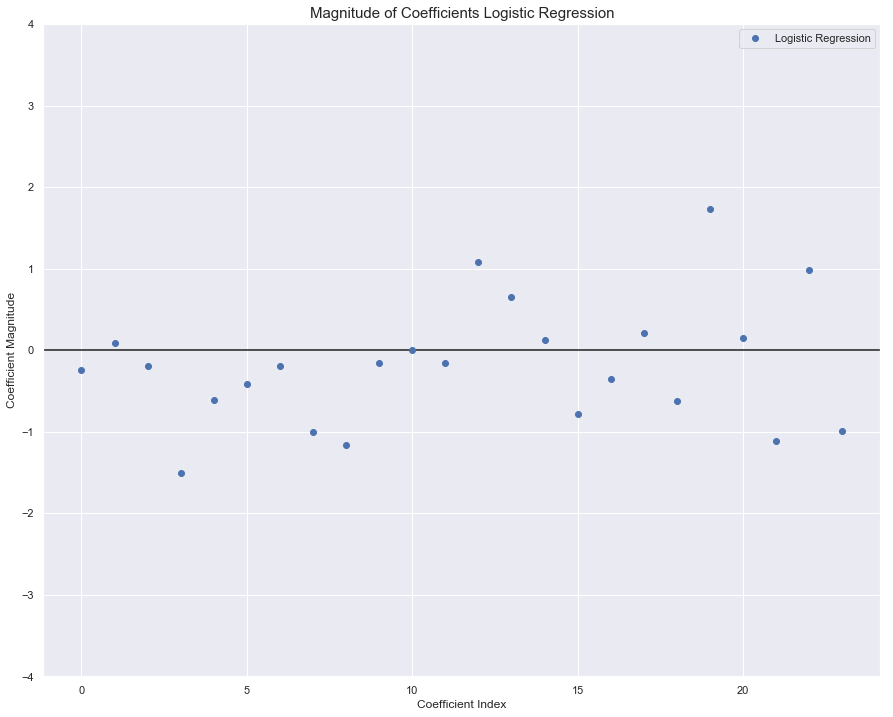

In [322]:
# Plotting the coefficients
f, ax = plt.subplots(figsize=(15, 12))

plt.plot(logreg.coef_.T, 'o', label="Logistic Regression")

plt.xlabel("Coefficient Index")
plt.ylabel("Coefficient Magnitude")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-4, 4)
plt.legend()
plt.title('Magnitude of Coefficients Logistic Regression', fontsize='15')

plt.savefig('Magnitude of Coefficients Logistic Regression')
plt.show();

### Decision Boundary Assumptions:
 - The decision boundaries for Fare and Age show that at around the age of 30 and a fare of 30 dollars, the probability of survival is around 40% and as the lines cross and progress the survival rate gets lower for ages 30 and above (yellow line), and the survival rate gets higher for fares that increase above 30 mark. 
 - However, there is a lot of overlap with just these two attributes, which makes classification difficult without others.

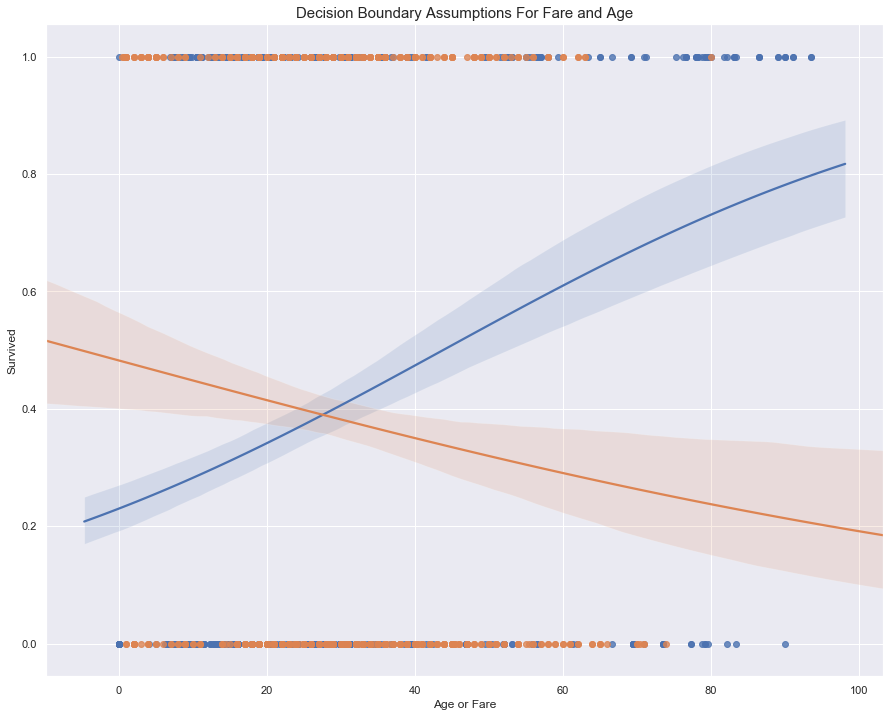

In [323]:
# Decision boundaries between Fare and Age. As fare increases probablity of survival increases, as age gets higher,
#probability of survival decreases
plt.figure(figsize=(15, 12))
sns.regplot(x = 'Fare', y ='Survived', x_ci='ci', scatter=True, data = by_title.loc[by_title['Fare'] < 100], logistic = True)
sns.regplot(x = 'Age', y ='Survived', x_ci='ci', scatter=True, data = by_title, logistic = True);
plt.xlabel('Age or Fare')
plt.title('Decision Boundary Assumptions For Fare and Age', fontsize='15')
plt.savefig('Decision Boundary Assumptions')
plt.show();

### Confusion Matrix:
 - Confusion matrix shows that 493 passengers were correctly classified as died, and 56 passengers were wrongly classified as survived. 90 passengers were wrongly classified as died, and 252 were correctly classified as survived.

In [324]:
#Confusion Matrix
y_train_pred = cross_val_predict(logreg, X_train, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[493,  56],
       [ 90, 252]], dtype=int64)

In [325]:
#Confusion Matrix by percentage
cm / cm.astype(np.float).sum(axis=1)

array([[0.89799636, 0.16374269],
       [0.16393443, 0.73684211]])

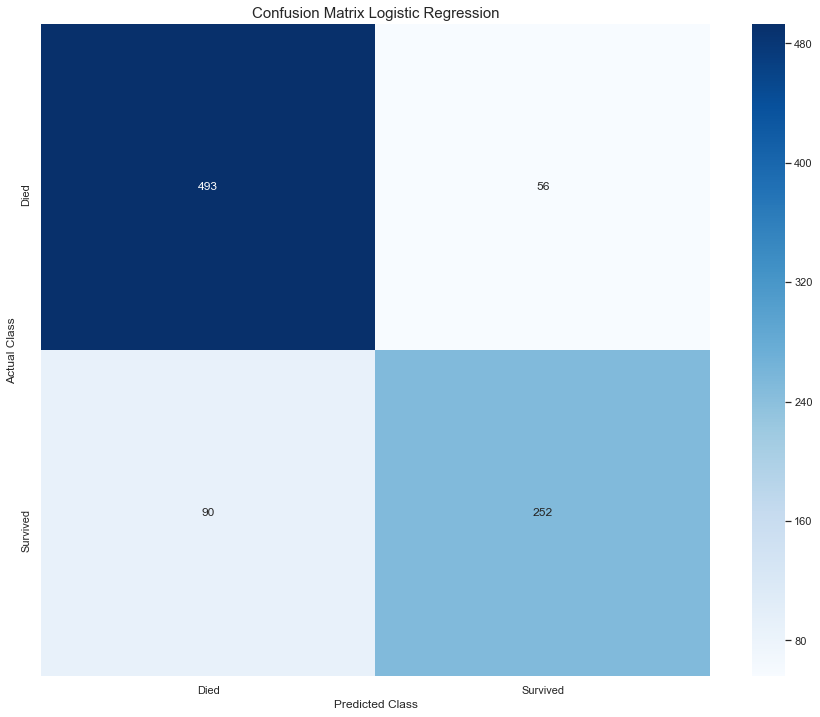

In [326]:
plt.figure(figsize=(15, 12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Class');ax.set_ylabel('Actual Class'); 
ax.set_title('Confusion Matrix Logistic Regression', fontsize='15'); 
ax.xaxis.set_ticklabels(['Died', 'Survived']); ax.yaxis.set_ticklabels(['Died', 'Survived'])
plt.savefig('Confusion Matrix Log reg')
plt.show();

### ROC Curve:
 - The ROC curve indicates that there were fewer type I and fewer type II errors, and that the model is a good measure of separability as it reproduces the data very well.
 - In summary, a ROC curve plots the true positive rate (recall) against the false positive rate (FPR), which is the ratio of negative instances that are incorrectly classified as positive. It is basically equal to one subtracted from the true negative rate, or the ratio of negative instances that are correctly classified as negative. Hence, the ROC curve plots the true positive rate versus one minus the true negative rate. 
 -  The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner). The model seems to do this pretty well. This was confirmed in the validation scores where the mean AUC was equal to 0.871.
 - However, since there were fewer positives (survived) than negatives (died) the model is further examined using the precision recall curve.

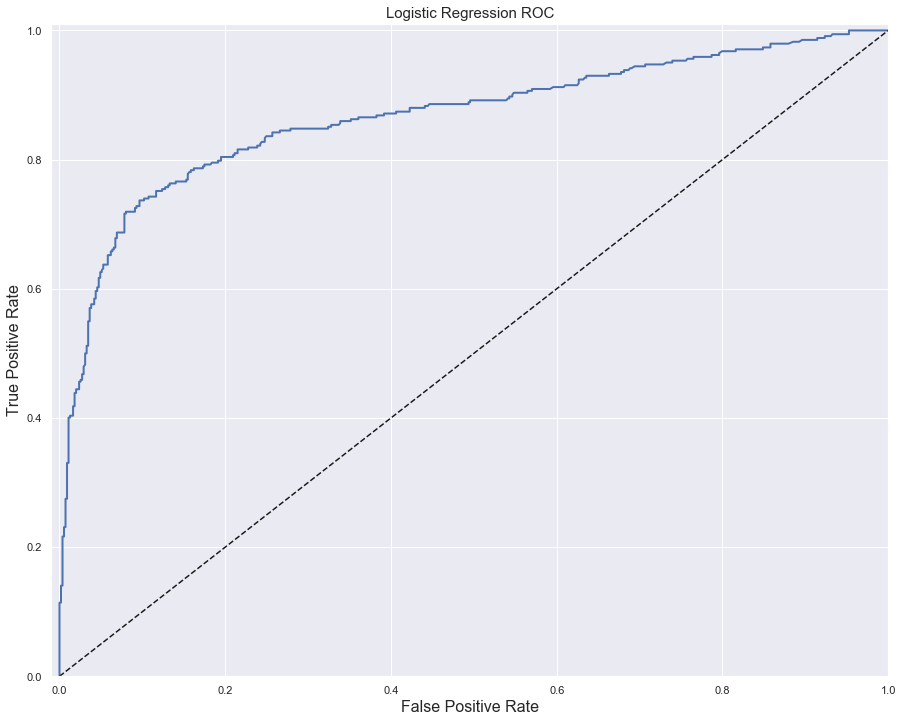

In [327]:
plot_roc_curve(logreg, X_train, y_train, 'Logistic Regression', 'Logistic Regression ROC')

### Precision Versus Recall:
 - The precision recall curve seems to support that the classifier is acceptable. The curve is close to the top right corner showing that precision does not drop sharply at the expense of higher recall. The mean f1 score of 0.773 seems to support this. Also, the mean score was at 0.818 while recall was at 0.737 indicating that the tradeoff was not terrible.
 - Precision is basically defined as the ratio of the number of true positives over true positives plus false positives. Recall is defined as the ratio of the number of true positives over true positives plus false negatives. Essentially, precision is a measure of exactness, and recall is a measure of completeness. The PR curve shows the trade-off between the two, the more precision the less recall, and vice versa. 

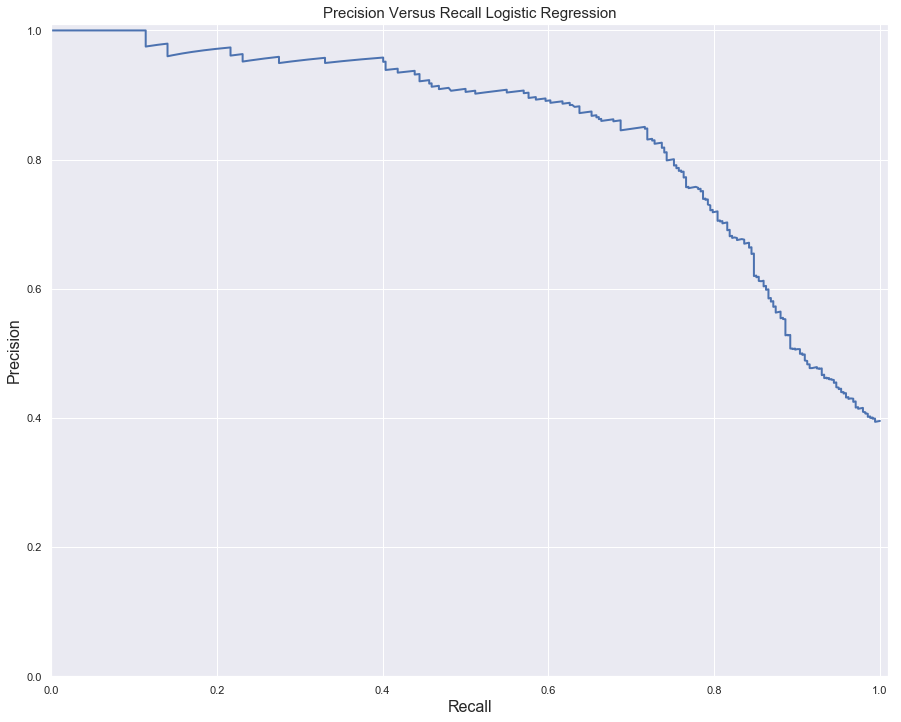

In [328]:
plot_precision_vs_recall(logreg, 'predict_proba', X_train, y_train, 'Precision Versus Recall Logistic Regression')

### Precision and Recall Versus Threshold:
 - The precision and recall versus threshold plot shows that the line between precision and recall crosses right before the threshold hits 0. At that threshold precision are recall are even at above 0.75 but below 0.80. At the threshold of 0 precision is a little above 0.80 and precision looks to be around 0.75. This is consistent with the mean precision score of 0.818, and recall score of 0.737. This tradeoff is significant when the threshold is set higher as recall drastically drops when it hits the threshold score of 1. However, at the threshold score of -1 precision is above 0.60 indicating that the tradeoff for recall is not as high as it is for precision. It is recommended that the threshold score remain unchanged.     

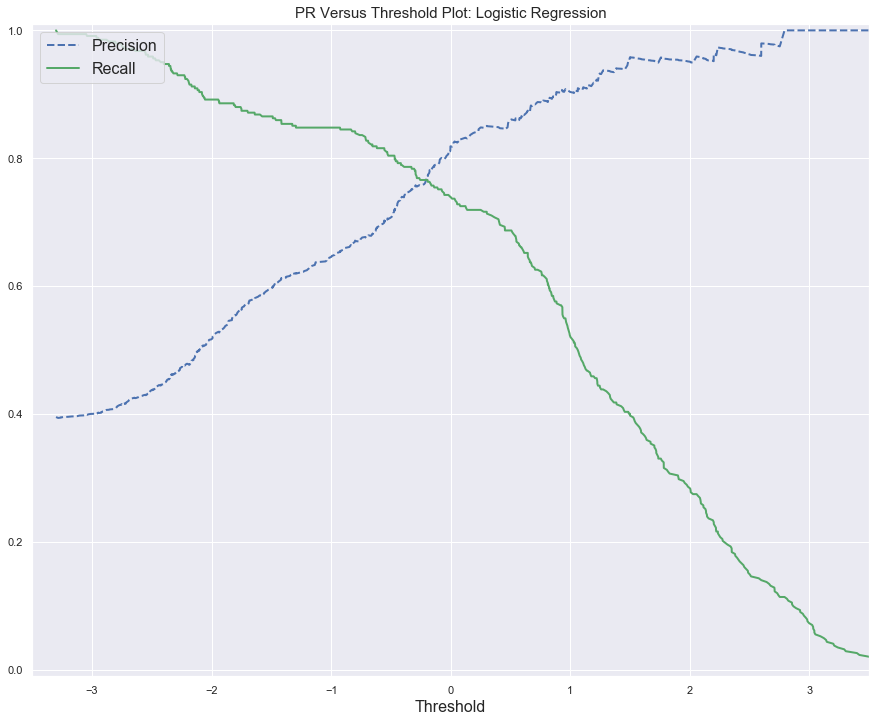

In [329]:
plot_precision_recall_vs_threshold(logreg, 'decision_function', X_train, y_train, -3.5, 3.5
                                   , 'PR Versus Threshold Plot: Logistic Regression')

### Learning Curve:
 - The learning curve for ROC AUC scores seems to show that the model may be severely underfitting the data as the gap between the curves are very narrow. However, the scores are not low which is a good sign. The gap at the beginning may also be an indicator of an overfitting model, but these were at training sizes of under 100. As the training sets get larger the model seems to generalize very well especially around the 600 mark. On the other hand, the gap seems to widen at the training set size of 800 which shows that the model may not be complex enough, or more data would be needed. As data from the Titanic is limited, a better evaluation model may be required.     

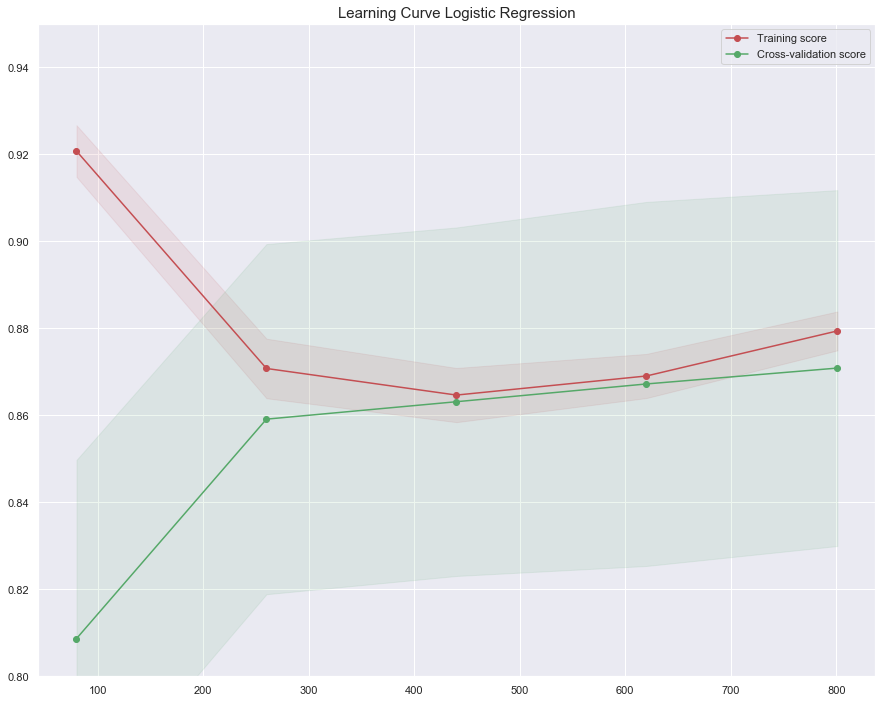

In [330]:
learning_plot(logreg, X_train, y_train, 0.80, 0.95, 'Learning Curve Logistic Regression')

## Naïve Bayes Using Gaussian NB:
 - Naive Bayes classifiers are a family of classifiers that are similar to linear models. However, they to be faster in training. But it comes at a cost. The price paid for efficiency is the naive Bayes models often provide generalization performance that is slightly worse than linear classifiers like Logistic Regression. 
 - Naive Bayes models are efficient because they learn parameters by looking at each feature individually and collect simple per class statistics from each feature.
 - The Gaussian model used below stores the average value and standard deviation of each feature for each class, and to make a prediction a data point is compared to the statistics for each of the classes, and the best matching class is predicted. 
 - The Gaussian model is mostly used on very high-dimensional data, it is very fast to train and predict, and the training procedure is very easy to understand. 
 - The model works very well with high-dimensional sparse data and are relatively robust to parameters. Naive Bayes models are great baseline models and are often used on very large datasets, where training even a linear model might take too long.
 - Assumes data is Gaussian, and can be applied to any continuous data.

### Scaling for Naive Bayes Using Min Max Scaler:
 - In essence Gaussian NB uses standardization internally. But Min Max Scaler was used as scoring faired better.

In [331]:
scaler = MinMaxScaler()

X_train_b = scaler.fit_transform(train_df)
X_test_b = scaler.transform(test_df)

### Validation Results:
 - Testing the training set using a 10 fold cross validation design showed a test mean ROC AUC score of 0.829, accuracy score of 0.763, with test precision and recall at 0.676 and 0.740. Test F1 score was 0.705.
 - The AUC value of 0.829 indicates that there were few type I and few type II errors, and that the model is a good measure of separability as it reproduces the data very well. However, the AUC score with Logistic Regression was significantly better.


In [332]:
#Binary classification using Gaussian NB classification with 10 fold cross validation score results of f1, precision, 
#recall, and ROC AUC

gaussian = GaussianNB()
gaussian.fit(X_train_b, y_train)

#Cross validation
scores = cross_validate(gaussian, X_train_b, y_train, cv = 10, scoring = {'f1', 'precision',
                                                                       'recall', 'accuracy', 'roc_auc'})

#Cross validation scores
scores_df = pd.DataFrame(scores).iloc[:,2:]
scores_df.columns.names=['cross_validation']
scores_df

cross_validation,test_recall,train_recall,test_precision,train_precision,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.657,0.720,0.575,0.695,0.678,0.772,0.613,0.707,0.766,0.850
1,0.714,0.726,0.658,0.686,0.744,0.768,0.685,0.706,0.831,0.851
2,0.647,0.776,0.647,0.699,0.730,0.786,0.647,0.735,0.788,0.856
3,0.882,0.782,0.682,0.685,0.798,0.778,0.769,0.730,0.889,0.845
4,0.794,0.747,0.675,0.710,0.775,0.786,0.730,0.728,0.809,0.853
5,0.735,0.776,0.676,0.699,0.764,0.786,0.704,0.735,0.813,0.852
6,0.706,0.776,0.686,0.699,0.764,0.786,0.696,0.735,0.814,0.848
7,0.647,0.802,0.688,0.694,0.753,0.788,0.667,0.744,0.797,0.848
8,0.824,0.789,0.778,0.681,0.843,0.777,0.800,0.731,0.891,0.843
9,0.794,0.776,0.692,0.693,0.784,0.782,0.740,0.732,0.897,0.843


In [333]:
#Test Statistics
scores_df.describe()

cross_validation,test_recall,train_recall,test_precision,train_precision,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.740,0.767,0.676,0.694,0.763,0.781,0.705,0.728,0.829,0.849
std,0.081,0.027,0.050,0.009,0.043,0.007,0.056,0.012,0.047,0.004
min,0.647,0.720,0.575,0.681,0.678,0.768,0.613,0.706,0.766,0.843
25%,0.669,0.754,0.662,0.688,0.747,0.777,0.671,0.728,0.800,0.846
50%,0.725,0.776,0.679,0.694,0.764,0.784,0.700,0.731,0.813,0.849
75%,0.794,0.781,0.687,0.699,0.782,0.786,0.737,0.735,0.875,0.852
max,0.882,0.802,0.778,0.710,0.843,0.788,0.800,0.744,0.897,0.856


### Exploration and Data Visualization of Gaussian NB:

### Confusion Matrix:
 - Confusion matrix shows that 427 passengers were correctly classified as died, and 122 passengers were wrongly classified as survived. 89 passengers were wrongly classified as died, and 253 were correctly classified as survived.

In [334]:
#Confusion Matrix
y_train_pred = cross_val_predict(gaussian, X_train_b, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[427, 122],
       [ 89, 253]], dtype=int64)

In [335]:
#Confusion Matrix by percentage
cm / cm.astype(np.float).sum(axis=1)

array([[0.77777778, 0.35672515],
       [0.16211293, 0.73976608]])

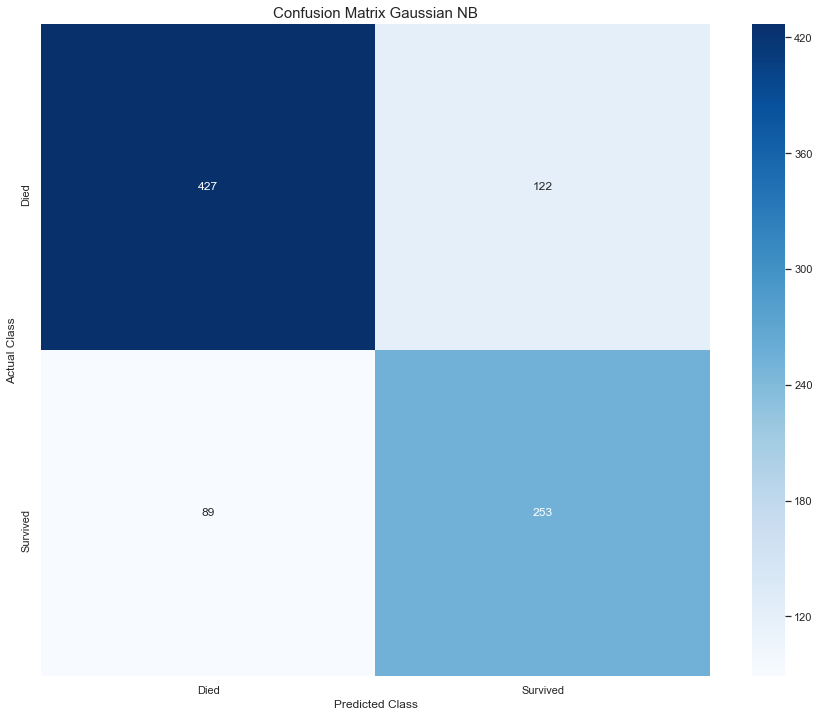

In [336]:
plt.figure(figsize=(15, 12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Class');ax.set_ylabel('Actual Class'); 
ax.set_title('Confusion Matrix Gaussian NB', fontsize='15'); 
ax.xaxis.set_ticklabels(['Died', 'Survived']); ax.yaxis.set_ticklabels(['Died', 'Survived'])
plt.savefig('Confusion Matrix Gaus')
plt.show();

### ROC Curve:
 - The ROC curve indicates that there were fewer type I and fewer type II errors, and that the model is an acceptable measure of separability as it reproduces the data very well. 
 - The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner). The model seems to do this pretty well. This was confirmed in the validation scores where the mean AUC was equal to 0.829. However, the curve is not as good as the one shown for Logistic Regression.
 - Since there were fewer positives (survived) than negatives (died) the model is further examined using the precision recall curve.

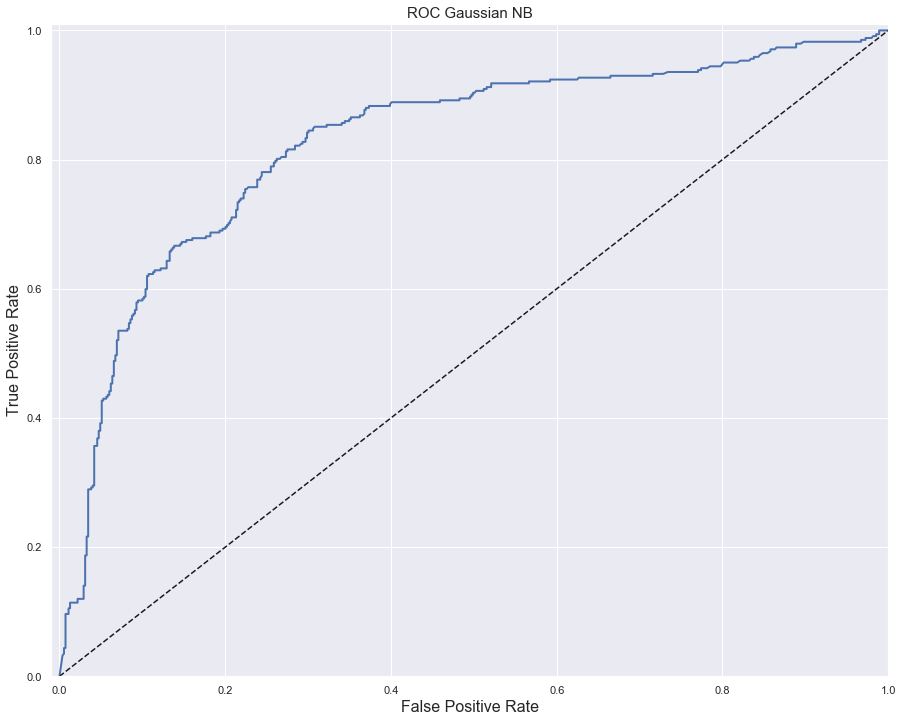

In [337]:
plot_roc_curve(gaussian, X_train_b, y_train, 'Gaussian', 'ROC Gaussian NB')

### Precision Versus Recall:
 - The precision recall curve shows a significant difference from the curve for Logistic Regression. The curve is jagged and does not get close to the top right corner. The curve seems to look flatter as well, which indicates that precision does not fall as steep as recall increases. However, the mean f1 score of 0.705 is much lower than Logistic regression. Also, the model seems to focus more on recall than precision as the mean score was 0.676 and the mean recall score was at 0.740 indicating that the tradeoff was not ideal.
 - Therefore, the curve shows that although the ROC curve and AUC score seemed okay, the PR curve shows that there is room for improvement. This is also supported by the confusion matrix as it showed a higher amount of false positives that Logistic Regression.


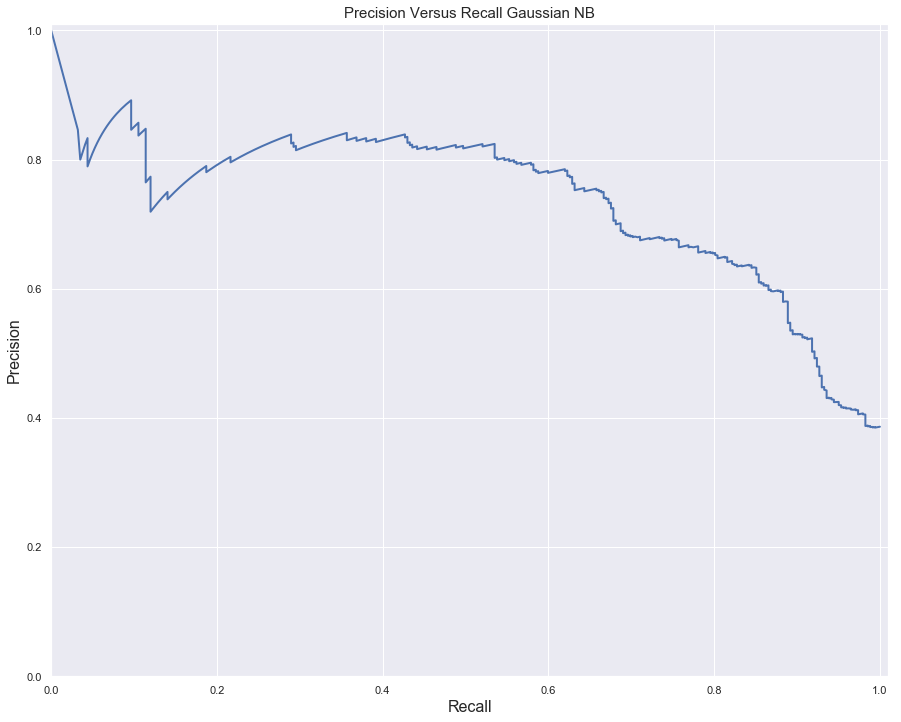

In [338]:
plot_precision_vs_recall(gaussian, 'predict_proba', X_train_b, y_train, 'Precision Versus Recall Gaussian NB')

### Precision and Recall Versus Threshold:
 - The precision and recall versus threshold plot shows that the line between precision and recall crosses around 0.8. At that intersection the scores look to be around 0.70. At the 0.5 point of the threshold, the lines separating the two seem to be in line with the precision and recall scores. It seems that if the threshold could be raised to around 0.8 the model would perform better with less false positives. This is recommended if possible. 

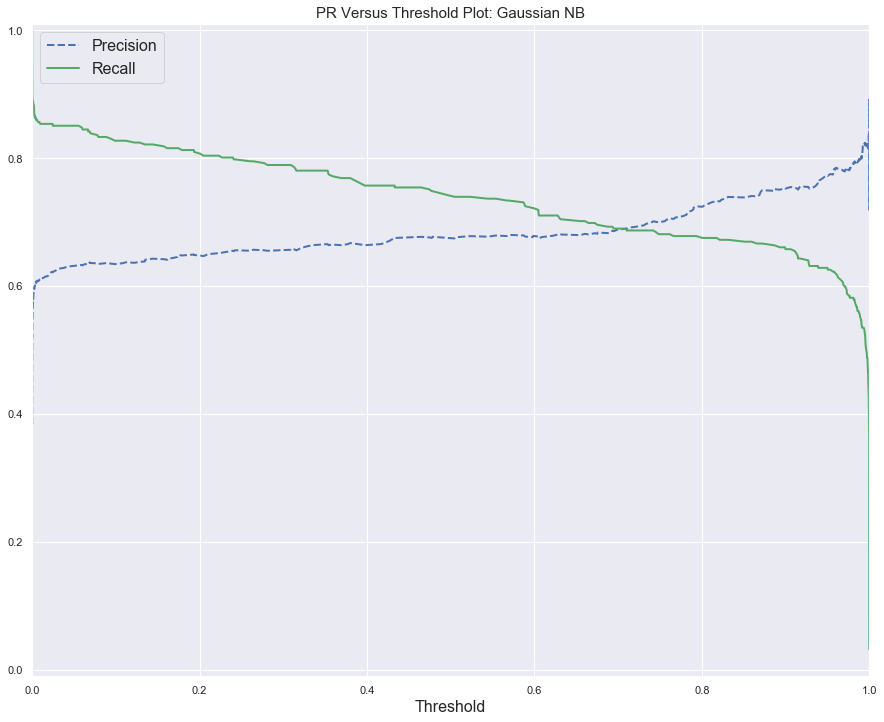

In [339]:
plot_precision_recall_vs_threshold(gaussian,'predict_proba', X_train_b, y_train, 0, 1, 
                                   'PR Versus Threshold Plot: Gaussian NB')

### Learning Curve:
 - The learning curve for Gaussian NB seems to show similarity with the learning curve for Logistic Regression. However, the gap is very wide in the beginning and though the cross validation line rises as the training set increases it starts to drop after the 400 mark. The gap then widens again showing that the model does not generalize as well as Logistic Regression. This indicates that a more complex model may be required. 

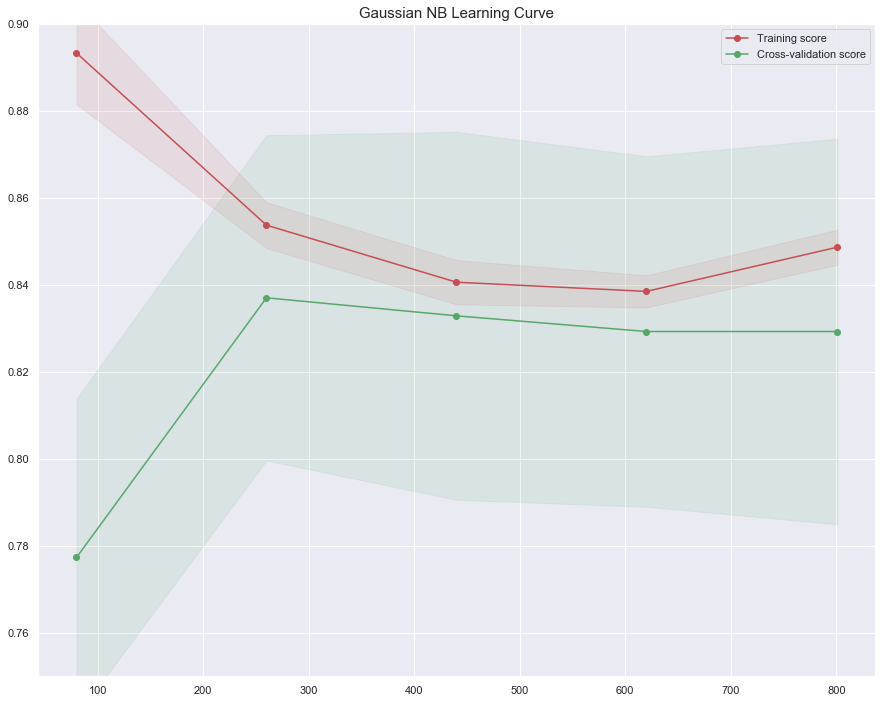

In [340]:
learning_plot(gaussian, X_train_b, y_train, 0.75, 0.90, 'Gaussian NB Learning Curve')

##  Naïve Bayes Using Bernoulli NB:

 - Like Gaussian NB, Bernoulli NB is a classifier that is similar to linear models. It is faster in training. But the price paid for efficiency provides generalization performance that is slightly worse than linear classifiers like Logistic Regression.
 - This model works very well with high-dimensional sparse data and is relatively robust to parameters. Bernoulli Naive Bayes models are great baseline models and are often used on very large datasets, where training even a linear model might take too long.
 - Bernoulli NB assumes that the data is binary. 
 - Bernoulli NB is mostly used for sparse count data such as text for text classification.
 - If handed any other kind of data, a BernoulliNB instance may binarize its input, such as in this case as not all data was binarized in preprocessing. 

### Validation Results:
 - Testing the training set using a 10 fold cross validation design showed a test mean ROC AUC score of 0.841, accuracy score of 0.773, with test precision and recall at 0.687 and 0.752. Test F1 score was 0.717.
 - The AUC value of 0.841 indicates that there were few type I and few type II errors, and that the model is a good measure of separability as it reproduces the data very well. However, the AUC score with Logistic Regression was significantly better, but this method performed better than Gaussian NB.


In [341]:
#Binary classification using Bernoulli NB classification with 10 fold cross validation score results of f1, precision, 
#recall, and ROC AUC

#Fit the model
bernoulli = BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True ) 
bernoulli.fit(X_train_b, y_train)

#Cross validation
scores = cross_validate(bernoulli, X_train_b, y_train, cv = 10, scoring = {'f1', 'precision',
                                                                       'recall', 'accuracy', 'roc_auc'})

#Cross validation scores
scores_df = pd.DataFrame(scores).iloc[:,2:]
scores_df.columns.names=['cross_validation']
scores_df

cross_validation,test_recall,train_recall,test_precision,train_precision,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.657,0.717,0.590,0.710,0.689,0.779,0.622,0.713,0.788,0.850
1,0.686,0.707,0.649,0.698,0.733,0.770,0.667,0.702,0.799,0.851
2,0.676,0.792,0.657,0.701,0.742,0.791,0.667,0.744,0.791,0.854
3,0.912,0.769,0.738,0.691,0.843,0.779,0.816,0.728,0.912,0.841
4,0.853,0.776,0.690,0.697,0.798,0.784,0.763,0.734,0.845,0.848
5,0.765,0.786,0.722,0.695,0.798,0.786,0.743,0.738,0.851,0.847
6,0.735,0.789,0.714,0.696,0.787,0.787,0.725,0.740,0.847,0.848
7,0.706,0.789,0.686,0.698,0.764,0.788,0.696,0.741,0.842,0.848
8,0.765,0.782,0.743,0.691,0.809,0.782,0.754,0.734,0.885,0.844
9,0.765,0.782,0.684,0.705,0.773,0.791,0.722,0.742,0.851,0.847


In [342]:
#Test Statistics
scores_df.describe()

cross_validation,test_recall,train_recall,test_precision,train_precision,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.752,0.769,0.687,0.698,0.773,0.784,0.717,0.732,0.841,0.848
std,0.080,0.031,0.047,0.006,0.044,0.006,0.056,0.014,0.040,0.004
min,0.657,0.707,0.590,0.691,0.689,0.770,0.622,0.702,0.788,0.841
25%,0.691,0.771,0.664,0.696,0.747,0.780,0.674,0.729,0.810,0.847
50%,0.750,0.782,0.688,0.697,0.780,0.785,0.723,0.736,0.846,0.848
75%,0.765,0.788,0.720,0.700,0.798,0.788,0.751,0.741,0.851,0.850
max,0.912,0.792,0.743,0.710,0.843,0.791,0.816,0.744,0.912,0.854


### Exploration and Data Visualization of Bernoulli NB:

### Confusion Matrix:
 - Confusion matrix shows that 432 passengers were correctly classified as died, and 117 passengers were wrongly classified as survived. 85 passengers were wrongly classified as died, and 257 were correctly classified as survived.

In [343]:
#Confusion Matrix
y_train_pred = cross_val_predict(bernoulli, X_train_b, y_train, cv=10)
cm = confusion_matrix(y_train, y_train_pred)
cm

array([[432, 117],
       [ 85, 257]], dtype=int64)

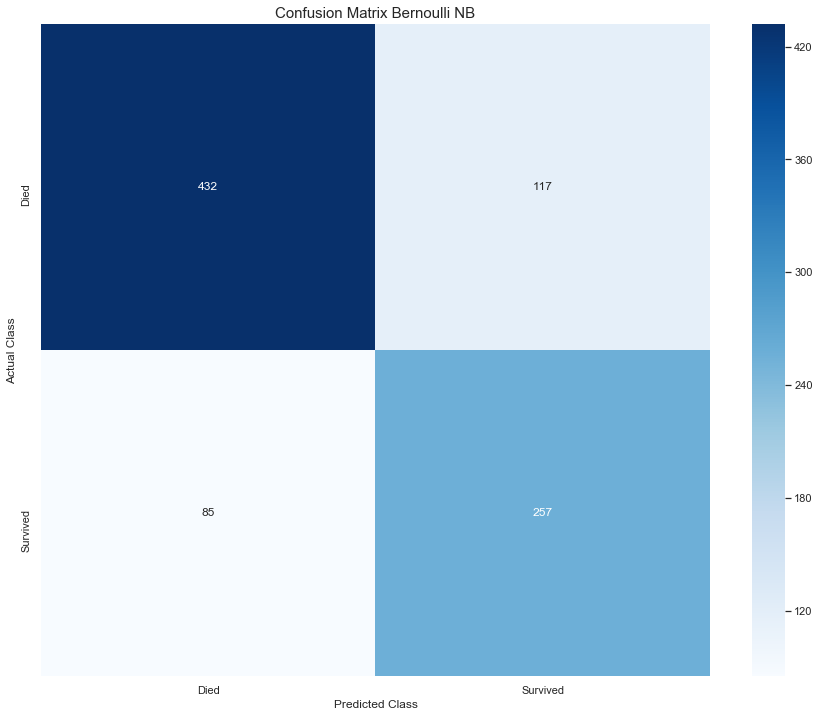

In [344]:
plt.figure(figsize=(15, 12))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted Class');ax.set_ylabel('Actual Class'); 
ax.set_title('Confusion Matrix Bernoulli NB', fontsize='15'); 
ax.xaxis.set_ticklabels(['Died', 'Survived']); ax.yaxis.set_ticklabels(['Died', 'Survived'])
plt.savefig('Confusion Matrix Bern')
plt.show();

### ROC Curve:
 - The ROC curve indicates that there were fewer type I and fewer type II errors, and that the model is an acceptable measure of separability as it reproduces the data very well. 
 - The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner). The model seems to do this pretty well. This was confirmed in the validation scores where the mean AUC was equal to 0.841. However, the curve is not as good as the one shown for Logistic Regression and may be better than Gaussian NB.
 - Since there were fewer positives (survived) than negatives (died) the model is further examined using the precision recall curve.

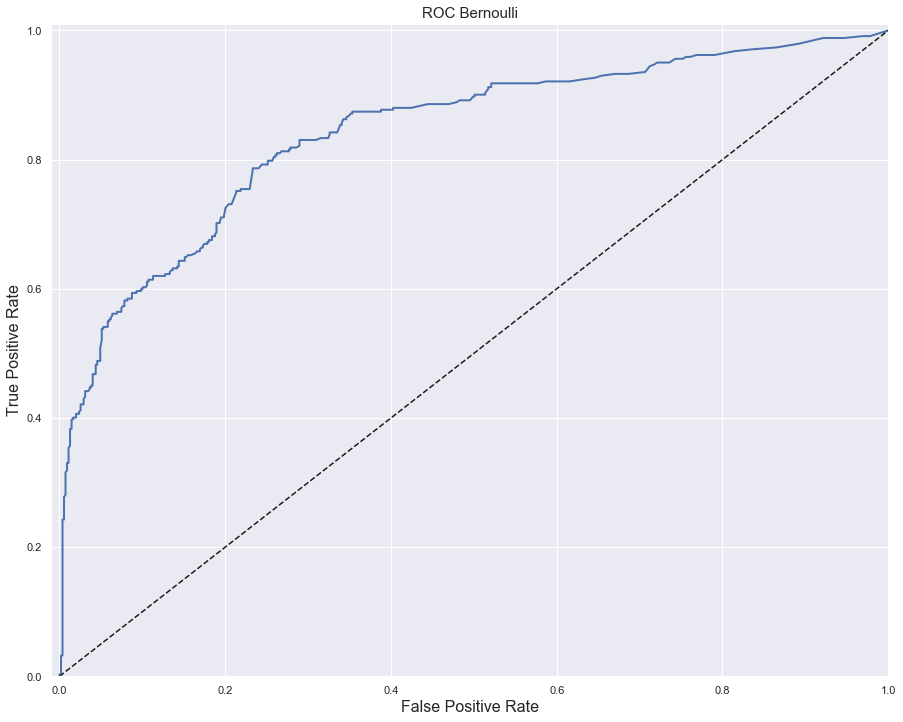

In [345]:
plot_roc_curve(bernoulli, X_train_b, y_train, 'Bernoulli', 'ROC Bernoulli')

### Precision Versus Recall:
 - The precision recall curve shows a significant difference from the curve for Logistic Regression. The curve is also jagged and does not get close to the top right corner, and it looks slightly worse than the curve for Gaussian NB as it significantly drops at 0.60 recall. Also, like Gaussian NB, the model seems to focus more on recall than precision as the mean score was 0.687 and the mean recall score was at 0.752 indicating that the tradeoff was not ideal.
 - Therefore, the curve shows that although the ROC curve and AUC score seemed okay, the PR curve shows that there is room for improvement. This is also supported by the confusion matrix as it showed a higher number of false positives that Logistic Regression, but less than Gaussian NB.

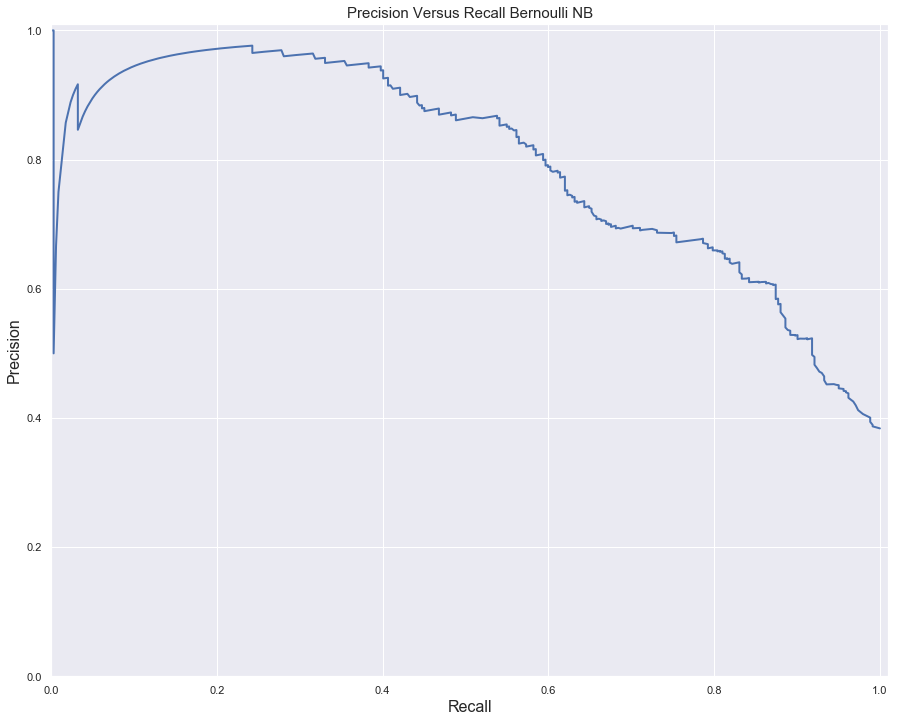

In [346]:
plot_precision_vs_recall(bernoulli, 'predict_proba', X_train_b, y_train, 'Precision Versus Recall Bernoulli NB')

### Precision and Recall Versus Threshold:
 - The precision and recall versus threshold plot shows that the line between precision and recall crosses around 0.6. At that intersection the scores look to be around 0.70. At the 0.5 point of the threshold, the lines separating the two seem to be in line with the precision and recall scores. It seems that if the threshold could be raised to around 0.7 the model would perform better with less false positives. This is recommended if possible. 

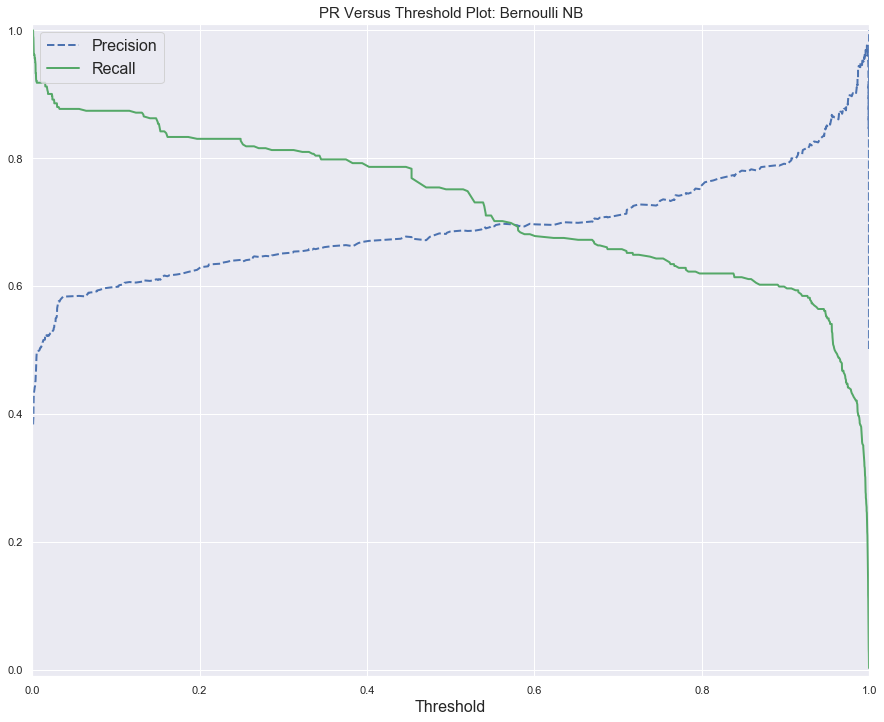

In [347]:
plot_precision_recall_vs_threshold(bernoulli,'predict_proba', X_train_b, y_train, 0, 1, 
                                   'PR Versus Threshold Plot: Bernoulli NB')

### Learning Curve:
 - The learning curve for ROC AUC scores seems to be very different from the other models. the cross validation scores rise as the training scores drop. They also cross at two points. This seems to be a classic sign of underfitting and the model may not generalize well to the test data. This indicates that a more complex model is required. 

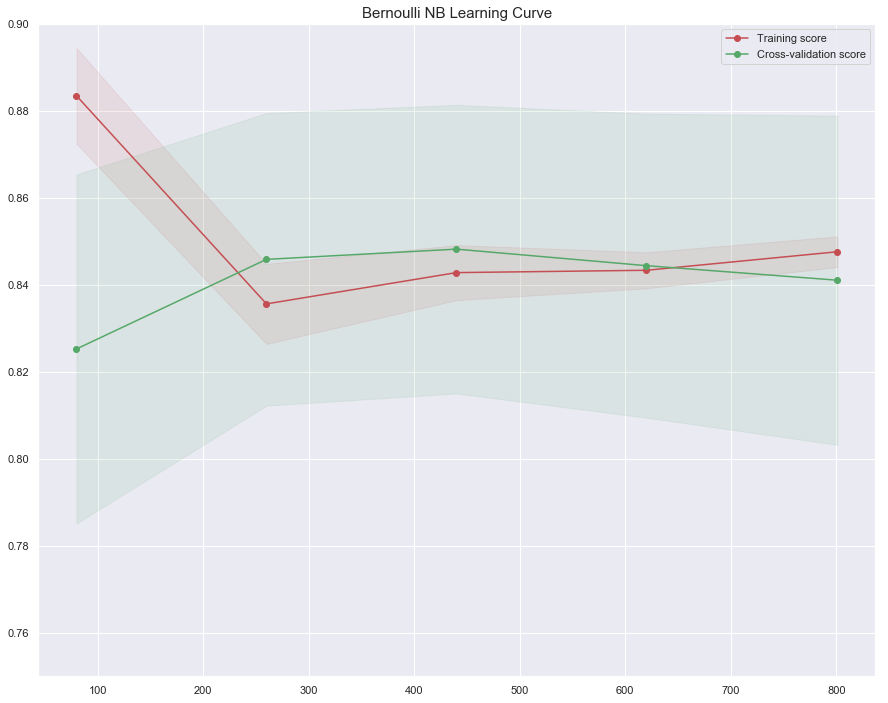

In [348]:
learning_plot(bernoulli, X_train_b, y_train, 0.75, 0.90, 'Bernoulli NB Learning Curve')

### ROC Curve Comparision of Three Classifiers:
 - The ROC curve comparing the three classifiers clearly shows that using Logistic Regression is the better of the three. It stays furthest away from the dotted line (toward the top-left corner) showing that the model was the best measure of separability, which is also shown in the confusion matrix. 
 - The PR curves also confirms this as the PR curve for Logistic Regression is closer to top right corner.
 - It is therefore recommended that the Logistic Regression model is used.

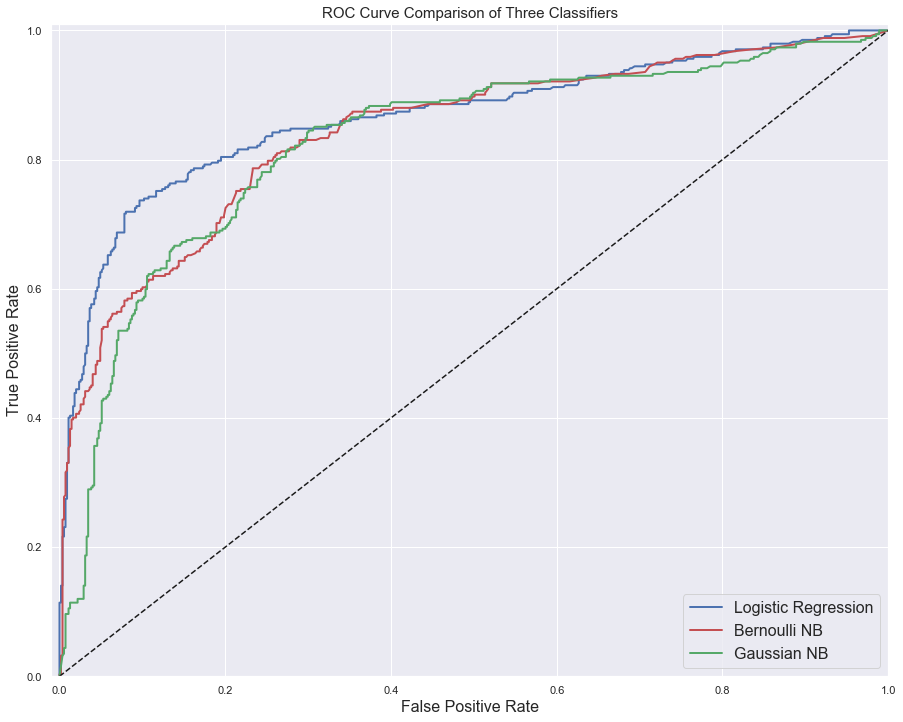

In [349]:
plot_roc_comp(logreg, bernoulli, gaussian, X_train, X_train_b, y_train, 'Logistic Regression', 'Bernoulli NB',
              'Gaussian NB', 'ROC Curve Comparison of Three Classifiers')

## Conclusion:
 - The main objective of this study is to test data using two binary classifiers: Logistic Regression and Naïve Bayes on the Titanic data set.
 - Cross-validation used was K-fold cross-validation, which randomly splits a training set into 10 distinct subsets called folds, then trains and evaluates the model n (i.e. 10) times, picking a different fold for evaluation every time and training on the other n (i.e. 9) folds.
 - Results showed that using a Logistic Regression performed the best as it scored with an average ROC AUC of 0.871 in a 10 fold cross-validation design.
 - Results also showed that the model with the best ROC curve, PR curve, PR versus threshold curve, and learning curve was Logistic Regression.
 - Accuracy score on the test set from Kaggle showed a score of 0.80382.


In [350]:
predict = logreg.predict(X_test)
submission = pd.DataFrame(test_ID, columns=['PassengerId'])
submission['Survived'] = predict
submission.to_csv('submission.csv', index=False)